In [11]:
import json
import os
def pct_box_to_abs(b, W, H):  # value={x,y,width,height} with percent
    x1 = b["x"]/100.0*W
    y1 = b["y"]/100.0*H
    x2 = (b["x"]+b["width"])/100.0*W
    y2 = (b["y"]+b["height"])/100.0*H
    return [x1,y1,x2,y2]

def load_label(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        d = json.load(f)
    anns = d["annotations"][0]["result"]
    W = anns[0]["original_width"]
    H = anns[0]["original_height"]
    gt_boxes = []
    gt_labels = []
    gt_texts = []
    for r in anns:
        v = r["value"]
        lbl = r["value"]["rectanglelabels"][0]
        box = pct_box_to_abs(v, W, H)
        text = v.get("contents", None)
        gt_boxes.append(box)
        gt_labels.append(lbl)
        gt_texts.append(text)
    # 이미지 경로
    img_key = os.path.basename(d["data"]["image"])[9:]
    # Return the image key and the three ground truth lists
    return img_key, gt_boxes, gt_labels, gt_texts

In [12]:
json_path = "data/ai_hub/preprocessed/pdf_annotation/HA_0032_0013970.json"
load_label(json_path)

('HA_0032_0013970.png',
 [[116.97033158813264,
   120.26527050610821,
   392.0977312390925,
   146.62478184991272],
  [118.6178010471204, 164.74694589877836, 555.197207678883, 502.478184991274],
  [115.32286212914485,
   525.542757417103,
   565.0820244328098,
   815.4973821989529]],
 ['Text', 'Text', 'Table'],
 ['332 김진경·이상목',
  '셋째, 제약회사 신약개발 CRA 실무 전문가, CTA 실무 전문가 양성 이를 위해서 본 학과에서는 2010년부터 생명의료윤리 전공의 특성화를 기획하였다. 그리고 2013년도에 철학과와 윤리문화학과를 통합하였고, 마침내 한국 최초로 학부에 생명의료윤리 전공을 개설하게 되었다. 학과 내에 <교과과정 위원회>를 두어 그 동안 계속된 교과과정의 개편을 통해 생명의료윤리 특성화 교육과정을 구성하여 운영하여 왔으며 2013년도 입학생들부터 적용될 생명의료윤리 전공 교육과정을 확정하였다. 생명의료윤리 전공 교과과정의 편성의 주요한 원칙은 의료 산업체에서 필요로 하는 교과목의 개발이었다. 이를 위해서 의료 산업체와의 긴밀한 협조(설문지 조사와 간담회)를 통해 그들이 필요로 하는 실무적인 내용을 교육과정에 포함시켰다. 그러한 실무 과목을 강의할 수 있는 강사를 대학 내 혹은 외부의 실무전문가를 초빙하여 강의를 하도록 하였다. 그리고 학생들의 강의 평가 결과를 참고하여 교과 내용에 관한 학생들의 바람이 무엇인가를 분석하여 교과목 개발에 사용하였다. 그 결과 학생들이 취업하여 큰 어려움 없이 현장 실무에 적응할 수 있게 되었다. 철학생명의료윤리학과에서는 2013학년도부터 다음과 같이 생명의료윤리 전공 특성화 교육 과정을 구성하여 교육하고 있다.',
  None])

In [4]:
import os, json, glob, math, time
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import numpy as np
import pandas as pd
from PIL import Image
from PIL import Image
import re, glob

IMG_EXTS = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")

def build_img_index(img_dir):
    """
    img_dir 하위 모든 이미지 파일을 인덱싱:
    - by_basename: {basename: [fullpaths]}
    - all_paths: 전체 경로 리스트
    """
    by_base = {}
    all_paths = []
    for p in glob.glob(os.path.join(img_dir, "**", "*"), recursive=True):
        if p.lower().endswith(IMG_EXTS) and os.path.isfile(p):
            b = os.path.basename(p)
            by_base.setdefault(b, []).append(p)
            all_paths.append(p)
    return by_base, all_paths

UUID_PREFIX = re.compile(r"^[0-9a-f]{8,}-", re.I)

def strip_uuid_prefix(basename: str) -> str:
    """'7e1d99b9-ST_0028_0010285.png' -> 'ST_0028_0010285.png'"""
    return UUID_PREFIX.sub("", basename.split("/", 1)[-1])

def pick_by_size(cands, W, H):
    """여러 후보가 있으면 (W,H) 일치하는 것을 우선 선택"""
    good=[]
    for p in cands:
        try:
            with Image.open(p) as im:
                if (im.width, im.height) == (W, H):
                    good.append(p)
        except:
            pass
    return good[0] if good else (cands[0] if cands else None)

def find_image_path(img_key, img_index, all_paths, W, H):
    """
    JSON이 주는 파일명과 실제 파일명이 다를 때 견고하게 찾기:
    1) 완전 동일 basename
    2) UUID 접두사 제거한 basename
    3) 전체 경로에서 '…/<basename without uuid>'로 끝나는 파일
    4) 위 후보들 중 (W,H) 일치하는 것 우선
    """
    base = os.path.basename(img_key)
    by_base, _ = img_index

    # 1) 그대로 찾기
    cands = by_base.get(base, [])

    # 2) UUID 접두사 제거한 이름으로 재시도
    alt = strip_uuid_prefix(base)
    if not cands and alt != base:
        cands = by_base.get(alt, [])

    # 3) suffix 검색 (하위폴더 위치 달라도 매칭)
    if not cands:
        suffix = alt
        cands = [p for p in all_paths if os.path.basename(p) == suffix]

    # 4) 크기로 disambiguation
    return pick_by_size(cands, W, H)


In [5]:

# === OCR 엔진 어댑터들 ===
class BaseOCREngine:
    name = "base"
    def ocr(self, img) -> str:
        raise NotImplementedError

class TesseractOCR(BaseOCREngine):
    name = "tesseract"
    def __init__(self):
        import pytesseract
        self.t = pytesseract
    def ocr(self, img) -> str:
        return self.t.image_to_string(img)

class EasyOCREngine(BaseOCREngine):
    name = "easyocr"
    def __init__(self, lang_list=None):
        import easyocr
        self.reader = easyocr.Reader(lang_list or ['ko','en'], gpu=True)
    def ocr(self, img) -> str:
        # concat line-wise text
        res = self.reader.readtext(np.array(img), detail=0, paragraph=True)
        return "\n".join(res)

class PaddleOCREngine(BaseOCREngine):
    name = "paddleocr"
    def __init__(self, lang='korean'):
        from paddleocr import PaddleOCR
        self.ocr_engine = PaddleOCR(use_angle_cls=True, lang=lang, show_log=False)
    def ocr(self, img) -> str:
        res = self.ocr_engine.ocr(np.array(img), cls=True)
        lines = []
        for page in res:
            for _, (text, conf) in page:
                lines.append(text)
        return "\n".join(lines)

# === 레이아웃(테이블/피겨) 검출 어댑터들 ===
class BaseLayoutDetector:
    name = "layout"
    # return list of (x1,y1,x2,y2,label,score)
    def detect(self, img: Image.Image) -> List[Tuple[float,float,float,float,str,float]]:
        raise NotImplementedError

def _lp_detectron_model(config_path, model_path, label_map):
    import layoutparser as lp
    return lp.Detectron2LayoutModel(
        config_path, model_path, extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5], label_map=label_map
    )

class Detectron2PubLayNet(BaseLayoutDetector):
    name = "d2_publaynet"
    def __init__(self):
        # layoutparser 모델 체크포인트 경로는 내부적으로 자동 다운로드됨
        self.label_map = {0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"}
        self.model = _lp_detectron_model(
            "lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config",
            "src/dectectors/PubLayNet/model_final.pth",
            self.label_map
        )
    def detect(self, img):
        layout = self.model.detect(np.array(img))
        out=[]
        for l in layout:
            x1,y1,x2,y2 = l.block.x_1, l.block.y_1, l.block.x_2, l.block.y_2
            out.append((x1,y1,x2,y2,l.type, float(l.score) if hasattr(l,'score') and l.score else 1.0))
        return out

class LayoutParserPRIMA(BaseLayoutDetector):
    name = "lp_prima"
    def __init__(self):
        # PRIMA Layout (문서 레이아웃) - 클래스명이 조금 다름
        self.label_map = {0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"}
        self.model = _lp_detectron_model(
            "lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config",
            'src/dectectors/PubLayNet/model_final.pth',
            self.label_map
        )
    def detect(self, img):
        layout = self.model.detect(np.array(img))
        out=[]
        for l in layout:
            x1,y1,x2,y2 = l.block.x_1, l.block.y_1, l.block.x_2, l.block.y_2
            out.append((x1,y1,x2,y2,l.type, float(l.score) if hasattr(l,'score') and l.score else 1.0))
        return out

class PPStructureDetector(BaseLayoutDetector):
    name = "pp_structure"
    def __init__(self):
        # PaddleOCR의 레이아웃 분석 모델(표/그림/본문 등)
        try:
            from paddleocr import PPStructure
        except ImportError:
            from paddleocr.ppstructure import PPStructure  # 구버전 경로
        self.PPStructure = PPStructure
        self.engine = PPStructure(layout=True, ocr=False, show_log=False)
    def detect(self, img):
        import cv2
        arr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        result = self.engine(arr)  # list of dicts with 'bbox' and 'type'
        out=[]
        for r in result:
            (x1,y1,x2,y2) = r['bbox']
            label = r.get('type','Text')
            out.append((x1,y1,x2,y2,label, 1.0))
        return out


In [6]:

# === 보조: 좌표 변환/크롭/IoU/편집거리 ===
def pct_box_to_abs(b, W, H):  # value={x,y,width,height} with percent
    x1 = b["x"]/100.0*W
    y1 = b["y"]/100.0*H
    x2 = (b["x"]+b["width"])/100.0*W
    y2 = (b["y"]+b["height"])/100.0*H
    return [x1,y1,x2,y2]

def crop(img: Image.Image, box):
    x1,y1,x2,y2 = map(int, box)
    x1=max(0,x1); y1=max(0,y1)
    x2=min(img.width, x2); y2=min(img.height, y2)
    return img.crop((x1,y1,x2,y2))

def iou(a,b):
    ax1,ay1,ax2,ay2=a; bx1,by1,bx2,by2=b
    inter_x1=max(ax1,bx1); inter_y1=max(ay1,by1)
    inter_x2=min(ax2,bx2); inter_y2=min(ay2,by2)
    iw=max(0, inter_x2-inter_x1); ih=max(0, inter_y2-inter_y1)
    inter=iw*ih
    if inter==0: return 0.0
    union=(ax2-ax1)*(ay2-ay1)+(bx2-bx1)*(by2-by1)-inter
    return inter/union if union>0 else 0.0

def levenshtein(a,b):
    la,lb=len(a),len(b)
    dp = list(range(lb+1))
    for i,ca in enumerate(a,1):
        prev=dp[0]; dp[0]=i
        for j,cb in enumerate(b,1):
            cur=dp[j]
            if ca==cb: dp[j]=prev
            else: dp[j]=min(prev+1, dp[j]+1, dp[j-1]+1)
            prev=cur
    return dp[lb]

# === 평가: OCR char-accuracy, detection mAP@0.5 ===
def eval_ocr_char_acc(pairs: List[Tuple[str,str]]) -> float:
    # pairs: list of (pred_text, gt_text)
    if not pairs: return float('nan')
    accs=[]
    for pred, gt in pairs:
        gt = (gt or "").strip()
        pred = (pred or "").strip()
        if len(gt)==0: continue
        dist=levenshtein(pred, gt)
        acc=max(0.0, 1.0 - dist/max(1,len(gt)))
        accs.append(acc)
    return float(np.mean(accs)) if accs else float('nan')

def eval_map50(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, target_classes=("Table","Figure")):
    # very simple AP@0.5 calculation over target classes
    aps=[]
    for cls in target_classes:
        # sort preds of this class by score desc
        P=[(b,s) for b,l,s in zip(pred_boxes,pred_labels,pred_scores) if l==cls]
        P.sort(key=lambda x:x[1], reverse=True)
        G=[b for b,l in zip(gt_boxes,gt_labels) if l==cls]
        matched=[False]*len(G)
        tp=[]; fp=[]
        for b,s in P:
            best_iou=0; best_j=-1
            for j,g in enumerate(G):
                if matched[j]: continue
                v=iou(b,g)
                if v>best_iou:
                    best_iou=v; best_j=j
            if best_iou>=0.5 and best_j!=-1:
                matched[best_j]=True; tp.append(1); fp.append(0)
            else:
                tp.append(0); fp.append(1)
        tp_cum=np.cumsum(tp); fp_cum=np.cumsum(fp)
        if len(P)==0:
            aps.append(float('nan')); continue
        recalls = tp_cum / max(1,len(G))
        precisions = tp_cum / np.maximum(1,(tp_cum+fp_cum))
        # AP: 11-point interpolation
        ap=0.0
        for r in np.linspace(0,1,11):
            p = np.max(precisions[recalls>=r]) if np.any(recalls>=r) else 0.0
            ap += p/11.0
        aps.append(ap)
    return float(np.nanmean(aps)) if aps else float('nan')

# === 데이터 로더 ===
def load_label(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        d=json.load(f)
    anns = d["annotations"][0]["result"]
    W=anns[0]["original_width"]; H=anns[0]["original_height"]
    gt_boxes=[]; gt_labels=[]; gt_texts=[]
    for r in anns:
        v=r["value"]; lbl=r["value"]["rectanglelabels"][0]
        box = pct_box_to_abs(v, W, H)
        text = v.get("contents", None)
        gt_boxes.append(box); gt_labels.append(lbl); gt_texts.append(text)
    # 이미지 경로
    img_key = d.get("file_upload") or os.path.basename(d["data"]["image"])
    return img_key, (gt_boxes, gt_labels, gt_texts, W, H)

# === 마스킹: 검출된 Table/Figure를 검은색으로 지우기(텍스트만 남김) ===
def mask_tables_figures(img: Image.Image, dets):
    arr = np.array(img).copy()
    for x1,y1,x2,y2,label,score in dets:
        if label in ("Table","Figure"):
            x1=int(max(0,x1)); y1=int(max(0,y1))
            x2=int(min(arr.shape[1],x2)); y2=int(min(arr.shape[0],y2))
            arr[y1:y2, x1:x2] = 255  # 흰색 마스킹
    return Image.fromarray(arr)

# === 조합 실행 ===
OCR_ENGINES = {
    "tesseract": TesseractOCR,
    "easyocr":  EasyOCREngine,
    "paddleocr": PaddleOCREngine,
}
LAYOUT_DETS = {
    "d2_publaynet": Detectron2PubLayNet,
    "lp_prima":     LayoutParserPRIMA,
    "pp_structure": PPStructureDetector,
}

@dataclass
class Combo:
    ocr: str
    det: str

def run_combo(img_dir, lbl_dir, combo: Combo, img_index=None, all_paths=None):
    # lazy init (모델 로딩)
    ocr = OCR_ENGINES[combo.ocr]()
    det = LAYOUT_DETS[combo.det]()
    rows=[]
    for jp in sorted(glob.glob(os.path.join(lbl_dir, "*.json"))):
        try:
            img_key, (gt_boxes, gt_labels, gt_texts) = load_label(jp)
            print(img_key)
            W = int(gt_boxes and (gt_boxes[0][2] or 0) or 0)  # placeholder… 필요시 load_label에서 W,H를 리턴하세요.
            H = int(gt_boxes and (gt_boxes[0][3] or 0) or 0)
            # 이미지 찾기: file_upload 또는 data/image basename 기준
            candidates = [os.path.join(img_dir, os.path.basename(img_key))]
            if not os.path.exists(candidates[0]):
                # 혹시나 json이 data/upload/... 로 저장된 경우도 대비
                base = os.path.basename(img_key)
                cand2 = glob.glob(os.path.join(img_dir, "**", base), recursive=True)
                candidates = cand2 or candidates
            if not candidates or not os.path.exists(candidates[0]):
                print(f"[warn] image not found for {jp}: {img_key}")
                continue
            img_path = find_image_path(img_key, img_index, all_paths, W, H)
            if not img_path:
                print(f"[warn] image not found for {jp}: {os.path.basename(img_key)}")
                continue
            img = Image.open(img_path).convert("RGB")

            # 레이아웃 검출
            dets = det.detect(img)
            pred_boxes=[(x1,y1,x2,y2) for (x1,y1,x2,y2,lab,sc) in dets]
            pred_labels=[lab for (_,_,_,_,lab,_) in dets]
            pred_scores=[sc for (*_,sc) in dets]

            # Detection 평가용 GT 수집
            det_gt_boxes=[]; det_gt_labels=[]
            for b,l in zip(gt_boxes, gt_labels):
                if l in ("Table","Figure"):
                    det_gt_boxes.append(b); det_gt_labels.append(l)
            map50 = eval_map50(pred_boxes, pred_labels, pred_scores, det_gt_boxes, det_gt_labels)

            # OCR: Table/Figure 마스킹 후, GT의 Text 박스만 크롭하여 평가
            masked = mask_tables_figures(img, dets)
            pairs=[]
            for b,l,t in zip(gt_boxes, gt_labels, gt_texts):
                if ((l=="Text") or (l=="Title")) and (t is not None) and str(t).strip()!="":
                    crop_img = crop(masked, b)
                    pred_text = ocr.ocr(crop_img)
                    pairs.append((pred_text, str(t)))
            char_acc = eval_ocr_char_acc(pairs)

            rows.append({
                "image": os.path.basename(img_path),
                "combo": f"{combo.ocr}+{combo.det}",
                "map50_table_figure": map50,
                "ocr_char_acc": char_acc,
                "num_text_gt": sum(1 for l,t in zip(gt_labels,gt_texts) if l=="Text" and t),
                "num_tf_gt": sum(1 for l in det_gt_labels if l in ("Table","Figure")),
            })
        except Exception as e:
            rows.append({
                "image": os.path.basename(jp),
                "combo": f"{combo.ocr}+{combo.det}",
                "map50_table_figure": np.nan,
                "ocr_char_acc": np.nan,
                "error": str(e)
            })
    df = pd.DataFrame(rows)
    return df

def main(img_dir, lbl_dir, out_csv="src/eval/results.csv"):
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    img_index = build_img_index(img_dir) 
    by_base, all_paths = img_index
    combos = [Combo(o,d) for o in OCR_ENGINES for d in LAYOUT_DETS]  # 3x3
    all_rows=[]
    for c in combos:
        print(f"==> Running {c.ocr}+{c.det}")
        df = run_combo(img_dir, lbl_dir, c, img_index=img_index, all_paths=all_paths)
        # 조합별 집계
        agg = df[["map50_table_figure","ocr_char_acc"]].mean(numeric_only=True).to_dict()
        agg["combo"] = f"{c.ocr}+{c.det}"
        agg["images"] = df.shape[0]
        print(f"   mAP@0.5={agg['map50_table_figure']:.3f}  OCR-char-acc={agg['ocr_char_acc']:.3f}")
        df.to_csv(out_csv.replace(".csv", f".{c.ocr}+{c.det}.csv"), index=False)
        all_rows.append(agg)
    pd.DataFrame(all_rows).to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

main("data/ai_hub/preprocessed/pdf_png", "data/ai_hub/preprocessed/pdf_annotation", "/runs")


==> Running tesseract+d2_publaynet


/home/skhong/ocr_proj/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   mAP@0.5=nan  OCR-char-acc=nan


PermissionError: [Errno 13] Permission denied: '/runs'

In [1]:
import os, re, json, glob, math
from typing import List, Tuple, Dict
from dataclasses import dataclass
import numpy as np
from PIL import Image
from tqdm import tqdm

# -------------------------
# 이미지 인덱싱/매칭 유틸
# -------------------------
IMG_EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
UUID_PREFIX = re.compile(r"^[0-9a-f]{8,}-", re.I)

def strip_uuid_prefix(name: str) -> str:
    return UUID_PREFIX.sub("", name)

def build_img_index(img_dir: str):
    by_base = {}
    all_paths = []
    for p in glob.glob(os.path.join(img_dir, "**", "*"), recursive=True):
        if os.path.isfile(p) and p.lower().endswith(IMG_EXTS):
            b = strip_uuid_prefix(os.path.basename(p))
            by_base.setdefault(b, []).append(p)
            all_paths.append(p)
    return by_base, all_paths

def find_page_image_for_json(json_path: str, img_index, all_imgs) -> str:
    """JSON에서 토큰 추출 → 이미지 폴더에서 매칭"""
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)

    # 후보 토큰: image_file_name 안의 핵심 코드(ex. HA_0032_0013970)
    tokens = set()
    for it in d.get("training_data_info", {}).get("image_info", []):
        fn = it.get("image_file_name", "") or ""
        # 가장 강한 패턴: 대문자+숫자 블록_숫자_숫자
        m = re.search(r"[A-Za-z]{2,}_\d{3,}_\d{3,}", fn)
        if m: tokens.add(m.group(0))
        # 백업: 숫자-숫자 블록
        m2 = re.search(r"\d{4,}_\d{4,}", fn)
        if m2: tokens.add(m2.group(0))

    # 파일명 자체로도 시도
    base_json = os.path.splitext(strip_uuid_prefix(os.path.basename(json_path)))[0]
    tokens.add(base_json)

    # 이미지 후보 수집
    cands = []
    for p in all_imgs:
        b = strip_uuid_prefix(os.path.basename(p))
        for t in tokens:
            if t and t in b:
                cands.append(p); break

    if cands:
        # 가장 짧은 경로(=대체로 정답 페이지) 우선
        cands.sort(key=len)
        return cands[0]

    # 백업: 같은 디렉터리 내 같은 stem 이름
    img_dir = os.path.dirname(json_path)
    for ext in IMG_EXTS:
        p = os.path.join(img_dir, base_json + ext)
        if os.path.exists(p): return p

    # 마지막 백업: 이미지 폴더에 하나만 있으면 그거
    if len(all_imgs) == 1:
        return all_imgs[0]

    return None

In [20]:
# -------------------------
# EMU → px 변환
# -------------------------
EMU_PER_INCH = 914400.0

def parse_xywh(loc) -> Tuple[float, float, float, float]:
    if isinstance(loc, (list, tuple)) and len(loc) == 4:
        return tuple(map(float, loc))
    if isinstance(loc, str):
        nums = re.findall(r"-?\d+(?:\.\d+)?", loc)
        if len(nums) >= 4:
            return tuple(map(float, nums[:4]))
    raise ValueError(f"Bad image_location: {loc!r}")

def emu_to_px(v: float, dpi=96.0) -> float:
    return v * (dpi / EMU_PER_INCH)

def loc_to_xyxy_px(loc, dpi=96.0) -> List[float]:
    x, y, w, h = parse_xywh(loc)
    x, y, w, h = emu_to_px(x, dpi), emu_to_px(y, dpi), emu_to_px(w, dpi), emu_to_px(h, dpi)
    return [x, y, x + w, y + h]

def image_info_to_gt(json_path: str, dpi=96.0):
    with open(json_path, "r", encoding="utf-8") as f:
        d = json.load(f)
    infos = d.get("training_data_info", {}).get("image_info", [])
    gts = []
    for it in infos:
        xyxy = loc_to_xyxy_px(it.get("image_location"), dpi=dpi)
        print(xyxy)
        # 라벨 추정: '그림'이면 Figure, '표'면 Table, 모르면 Figure
        name = (it.get("image_name") or "") + " " + (it.get("image_caption") or "")
        label = "Table" if ("표" in name) else "Figure"
        gts.append((xyxy, label))
    return gts

# -------------------------
# IoU / mAP@0.5
# -------------------------
def iou_xyxy(a, b) -> float:
    ax1, ay1, ax2, ay2 = a; bx1, by1, bx2, by2 = b
    iw = max(0.0, min(ax2, bx2) - max(ax1, bx1))
    ih = max(0.0, min(ay2, by2) - max(ay1, by1))
    inter = iw * ih
    if inter <= 0: return 0.0
    area_a = max(0.0, (ax2 - ax1)) * max(0.0, (ay2 - ay1))
    area_b = max(0.0, (bx2 - bx1)) * max(0.0, (by2 - by1))
    union = area_a + area_b - inter
    return inter / union if union > 0 else 0.0

def ap50(preds, gts, cls_name: str) -> float:
    """preds: [(xyxy, label, score)], gts: [(xyxy, label)]"""
    P = [(b,s) for (b,l,s) in preds if l==cls_name]
    G = [b for (b,l) in gts if l==cls_name]
    if len(P) == 0 and len(G) == 0: return np.nan  # 해당 클래스 없음
    if len(P) == 0: return 0.0
    P.sort(key=lambda x: x[1], reverse=True)
    matched = [False]*len(G)
    tp, fp = [], []
    for b, s in P:
        best_iou, best_j = 0.0, -1
        for j,g in enumerate(G):
            if matched[j]: continue
            v = iou_xyxy(b, g)
            if v > best_iou:
                best_iou, best_j = v, j
        if best_iou >= 0.5 and best_j != -1:
            matched[best_j] = True; tp.append(1); fp.append(0)
        else:
            tp.append(0); fp.append(1)
    tp = np.cumsum(tp); fp = np.cumsum(fp)
    recalls = tp / max(1, len(G))
    precisions = tp / np.maximum(1, tp+fp)
    ap = 0.0
    for r in np.linspace(0,1,11):
        p = np.max(precisions[recalls>=r]) if np.any(recalls>=r) else 0.0
        ap += p/11.0
    return ap

def map50(preds, gts, classes=("Table","Figure")) -> float:
    vals = [ap50(preds, gts, c) for c in classes]
    return float(np.nanmean(vals))


In [5]:

# -------------------------
# 레이아웃 디텍터 3종
# -------------------------
class BaseDet:
    def detect(self, img: Image.Image):
        raise NotImplementedError

class D2PubLayNet(BaseDet):
    def __init__(self, weight_path: str = None):
        import layoutparser as lp
        cfg = "lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config"
        if weight_path and os.path.isfile(weight_path):
            self.model = lp.Detectron2LayoutModel(cfg, weight_path,
                         extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                         label_map={0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"})
        else:
            # layoutparser가 내부 경로에서 모델 내려받아 사용
            self.model = lp.Detectron2LayoutModel(
                cfg, "lp://PubLayNet/faster_rcnn_R_50_FPN_3x/model",
                extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                label_map={0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"}
            )
    def detect(self, img):
        import numpy as np
        layout = self.model.detect(np.array(img))
        out=[]
        for l in layout:
            b = [l.block.x_1, l.block.y_1, l.block.x_2, l.block.y_2]
            sc = float(getattr(l, "score", 1.0) or 1.0)
            out.append((b, l.type, sc))
        return out

class LPPrima(BaseDet):
    def __init__(self, weight_path: str = None):
        import layoutparser as lp
        cfg = "lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config"
        if weight_path and os.path.isfile(weight_path):
            self.model = lp.Detectron2LayoutModel(cfg, weight_path,
                         extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                         label_map={0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"})
        else:
            self.model = lp.Detectron2LayoutModel(
                cfg, "lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/model",
                extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5],
                label_map={0:"Text",1:"Title",2:"List",3:"Table",4:"Figure"}
            )
    def detect(self, img):
        import numpy as np
        layout = self.model.detect(np.array(img))
        out=[]
        for l in layout:
            b = [l.block.x_1, l.block.y_1, l.block.x_2, l.block.y_2]
            sc = float(getattr(l, "score", 1.0) or 1.0)
            out.append((b, l.type, sc))
        return out

class PPStructureDet(BaseDet):
    def __init__(self):
        # PP-Structure 레이아웃은 ko 미지원 → 'en'로 고정
        from paddleocr import PPStructure
        self.engine = PPStructure(layout=True, ocr=False, show_log=False, lang='en')
    def detect(self, img):
        import cv2, numpy as np
        arr = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        res = self.engine(arr)  # [{'type': 'text'|..., 'bbox':[x1,y1,x2,y2]}, ...]
        out=[]
        for r in res:
            if "bbox" in r and "type" in r:
                x1,y1,x2,y2 = map(float, r["bbox"])
                t = r["type"]
                # PPStructure 타입명 보정
                if t.lower() == "table": label="Table"
                elif t.lower() in ("figure", "image", "pic"):
                    label="Figure"
                else:
                    label="Text"
                out.append(([x1,y1,x2,y2], label, 1.0))
        return out


In [6]:

# -------------------------
# 메인 배치 평가
# -------------------------
@dataclass
class OneResult:
    json_file: str
    image_file: str
    model: str
    map50: float
    ap50_table: float
    ap50_figure: float
    num_gt_table: int
    num_gt_figure: int
    num_pred: int

def evaluate_folder(img_dir: str, json_dir: str,
                    dpi: float = 96.0,
                    pub_pth: str = None,
                    pri_pth: str = None) -> List[OneResult]:

    by_base, all_imgs = build_img_index(img_dir)

    detectors = {
        "d2_publaynet": D2PubLayNet(pub_pth),
        "lp_prima":     LPPrima(pri_pth),
        "pp_structure": PPStructureDet(),
    }

    json_files = sorted(glob.glob(os.path.join(json_dir, "**", "*.json"), recursive=True))
    results = []

    for jp in tqdm(json_files, desc="Evaluate (per JSON)"):
        try:
            gts_xyxy = image_info_to_gt(jp, dpi=dpi)  # [(xyxy, label)]
            # 페이지 이미지 찾기
            img_path = find_page_image_for_json(jp, by_base, all_imgs)
            if not img_path or not os.path.exists(img_path):
                print(f"[WARN] page image not found for {os.path.basename(jp)}")
                continue

            img = Image.open(img_path).convert("RGB")

            # GT 요약
            gt_table = sum(1 for _,l in gts_xyxy if l=="Table")
            gt_figure = sum(1 for _,l in gts_xyxy if l=="Figure")

            for name, det in detectors.items():
                preds = det.detect(img)  # [(xyxy,label,score)]
                apT = ap50(preds, gts_xyxy, "Table")
                apF = ap50(preds, gts_xyxy, "Figure")
                m = float(np.nanmean([apT, apF]))
                results.append(OneResult(
                    json_file=os.path.relpath(jp, json_dir),
                    image_file=os.path.relpath(img_path, img_dir),
                    model=name,
                    map50=m,
                    ap50_table=apT,
                    ap50_figure=apF,
                    num_gt_table=gt_table,
                    num_gt_figure=gt_figure,
                    num_pred=len(preds),
                ))
        except Exception as e:
            print(f"[ERROR] {os.path.basename(jp)} -> {e}")

    return results



In [8]:
by_base, all_imgs = build_img_index("data/ai_hub/preprocessed/pptx_png")

# detectors = {
#     "d2_publaynet": D2PubLayNet(pub_pth),
#     "lp_prima":     LPPrima(pri_pth),
#     "pp_structure": PPStructureDet(),
# }
json_dir = "data/ai_hub/preprocessed/pptx_annotation"
json_files = sorted(glob.glob(os.path.join(json_dir, "**", "*.json"), recursive=True))
# results = []
json_files

['data/ai_hub/preprocessed/pptx_annotation/HA_0032_0013970.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0012075.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0012156.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0012562.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0012746.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0012778.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0013059.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0039_0013089.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0034701.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0035799.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0036280.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0036535.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0036824.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0037121.json',
 'data/ai_hub/preprocessed/pptx_annotation/HA_0047_0037681.json',
 'data/ai_

In [21]:

for jp in tqdm(json_files, desc="Evaluate (per JSON)"):
    gts_xyxy = image_info_to_gt(jp, dpi=96)  # [(xyxy, label)]
    # 페이지 이미지 찾기
    img_path = find_page_image_for_json(jp, by_base, all_imgs)
    if not img_path or not os.path.exists(img_path):
        print(f"[WARN] page image not found for {os.path.basename(jp)}")
        continue

    img = Image.open(img_path).convert("RGB")

    # GT 요약
    gt_table = sum(1 for _,l in gts_xyxy if l=="Table")
    print(gt_table)
    gt_figure = sum(1 for _,l in gts_xyxy if l=="Figure")


Evaluate (per JSON):   1%|          | 1/100 [00:00<00:15,  6.51it/s]

[0.014698162729658792, 0.36482939632545935, 0.14267716535433073, 0.44314960629921263]
[0.20010498687664044, 0.22866141732283465, 0.29375328083989505, 0.28976377952755905]
1
[0.029711286089238845, 0.31139107611548555, 0.08923884514435695, 0.3772178477690289]
[0.09112860892388452, 0.3110761154855643, 0.1582152230971129, 0.3769028871391076]
[0.17333333333333334, 0.10918635170603674, 0.31275590551181104, 0.13973753280839896]
[0.1731233595800525, 0.14708661417322835, 0.31275590551181104, 0.1816272965879265]
[0.26603674540682415, 0.2031496062992126, 0.3048818897637795, 0.24934383202099739]
[0.17973753280839896, 0.2779002624671916, 0.30383202099737533, 0.3254593175853019]
[0.17669291338582677, 0.3521259842519685, 0.23758530183727034, 0.4036745406824147]
[0.24062992125984253, 0.3521259842519685, 0.30078740157480316, 0.4035695538057743]
[0.033805774278215225, 0.24251968503937008, 0.1579002624671916, 0.3015223097112861]


Evaluate (per JSON):   3%|▎         | 3/100 [00:00<00:12,  8.02it/s]

7
[0.12136482939632547, 0.19233595800524936, 0.17501312335958005, 0.29396325459317585]
[0.17459317585301837, 0.19233595800524936, 0.22824146981627297, 0.29396325459317585]
[0.236745406824147, 0.19275590551181104, 0.288503937007874, 0.29438320209973756]
[0.29175853018372705, 0.19286089238845144, 0.34698162729658794, 0.29448818897637796]
[0.35328083989501313, 0.21480314960629923, 0.46173228346456696, 0.29364829396325465]
1
[0.01595800524934383, 0.2565879265091864, 0.10603674540682416, 0.31695538057742784]
[0.10614173228346457, 0.2565879265091864, 0.15811023622047243, 0.3365879265091864]
[0.02477690288713911, 0.3535958005249344, 0.085249343832021, 0.4342257217847769]
[0.08850393700787403, 0.3576902887139108, 0.1457217847769029, 0.43475065616797903]
[0.1941207349081365, 0.29175853018372705, 0.25133858267716536, 0.3673490813648294]
[0.27170603674540683, 0.2919685039370079, 0.31559055118110235, 0.3677690288713911]


Evaluate (per JSON):   5%|▌         | 5/100 [00:00<00:11,  8.57it/s]

0
[0.19538057742782153, 0.1378477690288714, 0.23695538057742782, 0.2405249343832021]
[0.23968503937007876, 0.1378477690288714, 0.30341207349081367, 0.18750656167979002]
[0.026351706036745408, 0.23506561679790028, 0.09123359580052492, 0.29333333333333333]
[0.026351706036745408, 0.2951181102362205, 0.09123359580052492, 0.33973753280839897]
[0.23968503937007876, 0.18929133858267716, 0.30341207349081367, 0.2406299212598425]
[0.09301837270341208, 0.23506561679790028, 0.14687664041994752, 0.3395275590551181]
[0.18299212598425196, 0.31811023622047246, 0.30719160104986876, 0.39433070866141734]
[0.02267716535433071, 0.33984251968503937, 0.15244094488188975, 0.3780577427821522]
0
[0.2558530183727034, 0.08661417322834646, 0.29669291338582676, 0.13984251968503936]
[0.1910761154855643, 0.08661417322834646, 0.22393700787401574, 0.13984251968503936]
[0.1805774278215223, 0.3053018372703412, 0.25963254593175855, 0.3658792650918635]
[0.27170603674540683, 0.2978477690288714, 0.3109711286089239, 0.3564304

Evaluate (per JSON):   8%|▊         | 8/100 [00:00<00:09,  9.48it/s]

1
[0.005354330708661418, 0.19590551181102364, 0.12146981627296588, 0.2456692913385827]
[0.009133858267716536, 0.2878740157480315, 0.05175853018372704, 0.34488188976377954]
[0.005354330708661418, 0.3640944881889764, 0.0700262467191601, 0.4495538057742782]
2
[0.058057742782152234, 0.19611548556430447, 0.13165354330708662, 0.2509186351706037]
[0.18918635170603676, 0.07958005249343832, 0.26236220472440946, 0.11695538057742783]
[0.26320209973753284, 0.07958005249343832, 0.33637795275590554, 0.11695538057742783]
[0.0672965879265092, 0.41700787401574807, 0.12220472440944882, 0.45490813648293965]
[0.03979002624671916, 0.36986876640419947, 0.14981627296587927, 0.4109186351706037]
1
[0.20304461942257218, 0.38330708661417323, 0.28125984251968505, 0.431496062992126]


Evaluate (per JSON):  10%|█         | 10/100 [00:01<00:09,  9.30it/s]

1
[0.16220472440944883, 0.19139107611548556, 0.3030971128608924, 0.27790026246719157]
[0.16220472440944883, 0.28188976377952757, 0.3040419947506562, 0.318005249343832]
[0.3283989501312336, 0.1858267716535433, 0.44493438320209977, 0.2211023622047244]
[0.3283989501312336, 0.22330708661417323, 0.44493438320209977, 0.2614173228346457]
0
[0.18950131233595802, 0.30750656167979, 0.30215223097112864, 0.36167979002624673]
[0.18950131233595802, 0.07863517060367455, 0.3046719160104987, 0.1463517060367454]
[0.18950131233595802, 0.36167979002624673, 0.30215223097112864, 0.4114435695538058]


Evaluate (per JSON):  12%|█▏        | 12/100 [00:01<00:08, 10.10it/s]

0
[0.17343832020997377, 0.08745406824146983, 0.2613123359580053, 0.14918635170603675]
[0.26456692913385826, 0.08671916010498688, 0.3165354330708661, 0.1504461942257218]
1
[0.0426246719160105, 0.375748031496063, 0.08692913385826773, 0.4422047244094488]
[0.09175853018372704, 0.375748031496063, 0.1362729658792651, 0.4232020997375328]
0
[0.011443569553805774, 0.32178477690288715, 0.08535433070866143, 0.4539632545931759]
[0.08545931758530184, 0.32178477690288715, 0.16230971128608923, 0.4073490813648294]
[0.08545931758530184, 0.40892388451443573, 0.16230971128608923, 0.4555380577427822]
[0.170498687664042, 0.28325459317585305, 0.3122309711286089, 0.34183727034120737]


Evaluate (per JSON):  16%|█▌        | 16/100 [00:01<00:08, 10.31it/s]

1
[0.1746981627296588, 0.3164304461942257, 0.3299737532808399, 0.33018372703412074]
[0.1746981627296588, 0.33081364829396326, 0.3299737532808399, 0.39506561679790025]
[0.17711286089238845, 0.09396325459317585, 0.25280839895013124, 0.10488188976377953]
[0.17711286089238845, 0.10498687664041995, 0.25280839895013124, 0.13480314960629922]
[0.17711286089238845, 0.13490813648293964, 0.2531233595800525, 0.16073490813648295]
[0.25280839895013124, 0.09385826771653544, 0.3299737532808399, 0.16073490813648295]
4
[0.30635170603674544, 0.08167979002624673, 0.4535433070866142, 0.13406824146981627]
[0.30635170603674544, 0.13658792650918636, 0.4535433070866142, 0.20713910761154858]
2
[0.24377952755905513, 0.062362204724409454, 0.32041994750656166, 0.1767979002624672]
[0.16545931758530186, 0.2984776902887139, 0.321994750656168, 0.3298687664041995]
[0.012703412073490815, 0.2984776902887139, 0.15821522309711286, 0.33018372703412074]


Evaluate (per JSON):  18%|█▊        | 18/100 [00:01<00:07, 10.68it/s]

0
[0.20703412073490815, 0.30026246719160105, 0.3163254593175853, 0.34551181102362205]
[0.20703412073490815, 0.21217847769028872, 0.3163254593175853, 0.29312335958005253]
0
[0.1767979002624672, 0.21763779527559057, 0.3209448818897638, 0.25385826771653547]
[0.013333333333333334, 0.26173228346456695, 0.15748031496062992, 0.285249343832021]
0
[0.22068241469816274, 0.1335433070866142, 0.3218897637795276, 0.21574803149606303]
[0.22068241469816274, 0.2130183727034121, 0.3230446194225722, 0.2651968503937008]
[0.22068241469816274, 0.2772703412073491, 0.3230446194225722, 0.37385826771653546]


Evaluate (per JSON):  22%|██▏       | 22/100 [00:02<00:06, 11.29it/s]

0
[0.06005249343832021, 0.30225721784776904, 0.11328083989501313, 0.3464566929133858]
1
[0.12146981627296588, 0.09343832020997375, 0.21228346456692915, 0.12461942257217848]
1
[0.24640419947506562, 0.07254593175853019, 0.295748031496063, 0.12692913385826773]
[0.29879265091863516, 0.07296587926509186, 0.3445669291338583, 0.12766404199475065]
[0.3478215223097113, 0.07275590551181102, 0.39716535433070865, 0.12713910761154856]
[0.40062992125984254, 0.07244094488188976, 0.44860892388451445, 0.1268241469816273]


Evaluate (per JSON):  24%|██▍       | 24/100 [00:02<00:06, 11.05it/s]

0
[0.04955380577427822, 0.30782152230971127, 0.13427821522309713, 0.40073490813648294]
[0.1994750656167979, 0.2915485564304462, 0.29112860892388454, 0.3426771653543307]
[0.2047244094488189, 0.3485564304461942, 0.28976377952755905, 0.40073490813648294]
3
[0.05553805774278216, 0.28619422572178477, 0.12881889763779528, 0.34131233595800525]
[0.17270341207349083, 0.07275590551181102, 0.30771653543307087, 0.1400524934383202]
0
[0.01732283464566929, 0.33249343832021, 0.08587926509186351, 0.37396325459317586]
[0.08692913385826773, 0.33249343832021, 0.156745406824147, 0.3740682414698163]
[0.1773228346456693, 0.21280839895013123, 0.3176902887139108, 0.25627296587926507]
[0.1773228346456693, 0.2563779527559055, 0.31622047244094487, 0.2935433070866142]


Evaluate (per JSON):  28%|██▊       | 28/100 [00:02<00:06, 10.63it/s]

1
[0.014173228346456693, 0.28545931758530185, 0.0857742782152231, 0.3729133858267717]
[0.08703412073490814, 0.2850393700787402, 0.15863517060367455, 0.3729133858267717]
[0.02530183727034121, 0.37385826771653546, 0.14729658792650918, 0.4551181102362205]
0
[0.22876640419947508, 0.0773753280839895, 0.31527559055118115, 0.13795275590551181]
[0.1725984251968504, 0.3201049868766404, 0.2274015748031496, 0.4116535433070866]
[0.017217847769028873, 0.2136482939632546, 0.15107611548556432, 0.27023622047244095]
[0.017217847769028873, 0.27023622047244095, 0.15128608923884515, 0.40892388451443573]
[0.18341207349081365, 0.14246719160104987, 0.24944881889763781, 0.1904461942257218]
[0.18341207349081365, 0.07727034120734909, 0.2274015748031496, 0.13816272965879267]
[0.2516535433070866, 0.14225721784776904, 0.2837795275590551, 0.18939632545931762]
[0.28598425196850397, 0.14246719160104987, 0.3213648293963255, 0.19244094488188976]
4
[0.01910761154855643, 0.21291338582677166, 0.16083989501312335, 0.274960

Evaluate (per JSON):  30%|███       | 30/100 [00:03<00:07,  9.92it/s]

2
[0.0394750656167979, 0.11454068241469817, 0.07779527559055119, 0.18383202099737533]
[0.09291338582677165, 0.11454068241469817, 0.13301837270341207, 0.1830971128608924]
[0.11107611548556431, 0.2857742782152231, 0.1630446194225722, 0.35338582677165353]
[0.013543307086614173, 0.288503937007874, 0.10194225721784778, 0.35433070866141736]
[0.19884514435695538, 0.12671916010498688, 0.28503937007874014, 0.1921259842519685]
[0.226246719160105, 0.28188976377952757, 0.3225196850393701, 0.3521259842519685]
[0.17081364829396325, 0.2810498687664042, 0.219002624671916, 0.3530708661417323]
2
[0.1763779527559055, 0.13658792650918636, 0.25123359580052496, 0.1930708661417323]
[0.1752230971128609, 0.1930708661417323, 0.25249343832021, 0.25490813648293964]
[0.2579527559055118, 0.13721784776902887, 0.30446194225721784, 0.2523884514435696]
[0.015853018372703413, 0.2804199475065617, 0.059842519685039376, 0.37963254593175855]
[0.1815223097112861, 0.3485564304461942, 0.243989501312336, 0.4]
[0.246929133858267

Evaluate (per JSON):  32%|███▏      | 32/100 [00:03<00:06,  9.85it/s]

3
[0.18194225721784776, 0.19433070866141733, 0.23286089238845142, 0.2732808398950131]
[0.24934383202099739, 0.18551181102362205, 0.31118110236220475, 0.23506561679790028]
[0.24850393700787402, 0.24818897637795276, 0.3103412073490814, 0.2928083989501312]
[0.12566929133858268, 0.3399475065616798, 0.18960629921259842, 0.38729658792650923]
[0.1994750656167979, 0.3288188976377953, 0.24514435695538056, 0.3980052493438321]
[0.2693963254593176, 0.32871391076115486, 0.3130708661417323, 0.3981102362204725]
2
[0.011863517060367455, 0.21280839895013123, 0.15758530183727035, 0.26656167979002626]
[0.011863517060367455, 0.13018372703412073, 0.07044619422572179, 0.20230971128608924]
[0.013123359580052493, 0.3408923884514436, 0.15769028871391078, 0.3876115485564305]
[0.012493438320209974, 0.3909711286089239, 0.15706036745406823, 0.4615223097112861]
[0.23821522309711288, 0.0862992125984252, 0.3212598425196851, 0.1415223097112861]
[0.17648293963254594, 0.1825721784776903, 0.3215748031496063, 0.2422047244

Evaluate (per JSON):  35%|███▌      | 35/100 [00:03<00:06,  9.66it/s]

6
[0.17480314960629922, 0.1826771653543307, 0.23443569553805776, 0.21742782152230972]
[0.23979002624671916, 0.19548556430446196, 0.3229396325459318, 0.21417322834645672]
[0.05564304461942257, 0.2599475065616798, 0.11664041994750657, 0.2927034120734908]
[0.029396325459317585, 0.3278740157480315, 0.14288713910761155, 0.3571653543307087]
[0.058582677165354334, 0.37826771653543306, 0.11349081364829397, 0.4156430446194226]
[0.22509186351706037, 0.25963254593175855, 0.273490813648294, 0.2971128608923885]
[0.186246719160105, 0.33711286089238846, 0.3123359580052494, 0.3688188976377953]
[0.186246719160105, 0.37826771653543306, 0.3123359580052494, 0.41238845144356956]
2
[0.025511811023622048, 0.42446194225721784, 0.13847769028871393, 0.4580577427821522]
[0.19611548556430447, 0.06855643044619422, 0.29112860892388454, 0.20167979002624672]
[0.1931758530183727, 0.17774278215223097, 0.3006824146981627, 0.3151706036745407]
[0.19926509186351707, 0.3005774278215223, 0.2879790026246719, 0.354960629921259

Evaluate (per JSON):  37%|███▋      | 37/100 [00:03<00:05, 10.68it/s]

3
[0.20598425196850395, 0.15926509186351706, 0.29427821522309716, 0.2316010498687664]
[0.20829396325459318, 0.24346456692913387, 0.2919685039370079, 0.34267716535433074]
[0.19748031496062993, 0.35443569553805776, 0.30288713910761156, 0.40545931758530185]
3
[0.19506561679790027, 0.23118110236220474, 0.28818897637795277, 0.30446194225721784]
1
[0.008188976377952756, 0.3925459317585302, 0.16062992125984255, 0.4358005249343832]
[0.1783727034120735, 0.2447244094488189, 0.3170603674540683, 0.3648293963254593]
[0.17753280839895014, 0.09217847769028872, 0.3179002624671916, 0.23086614173228348]


Evaluate (per JSON):  41%|████      | 41/100 [00:04<00:05, 11.01it/s]

0
[0.08556430446194226, 0.3827821522309711, 0.15874015748031495, 0.4477690288713911]
[0.19601049868766404, 0.12535433070866142, 0.3006824146981627, 0.21732283464566932]
[0.24188976377952756, 0.27380577427821523, 0.3206299212598425, 0.36073490813648296]
0
[0.17616797900262468, 0.07391076115485565, 0.3212598425196851, 0.11296587926509187]
[0.18341207349081365, 0.18173228346456693, 0.3151706036745407, 0.26173228346456695]
0
[0.027926509186351707, 0.34173228346456697, 0.14551181102362204, 0.41301837270341213]
[0.17133858267716537, 0.10477690288713912, 0.318740157480315, 0.16083989501312337]


Evaluate (per JSON):  43%|████▎     | 43/100 [00:04<00:05, 10.55it/s]

1
[0.02320209973753281, 0.24955380577427821, 0.16136482939632546, 0.29396325459317585]
[0.04073490813648294, 0.3723884514435696, 0.14509186351706038, 0.4172178477690289]
[0.20640419947506564, 0.21847769028871392, 0.32745406824146983, 0.3088713910761155]
[0.20934383202099738, 0.3477165354330709, 0.32440944881889766, 0.39527559055118117]
0
[0.03254593175853018, 0.2934383202099738, 0.1421522309711286, 0.329238845144357]
[0.03254593175853018, 0.34498687664041994, 0.1421522309711286, 0.3807874015748031]
[0.03254593175853018, 0.39916010498687665, 0.1421522309711286, 0.4422047244094488]
[0.19139107611548556, 0.22446194225721786, 0.300997375328084, 0.3057217847769029]
3


Evaluate (per JSON):  45%|████▌     | 45/100 [00:04<00:05,  9.98it/s]

[0.029501312335958006, 0.26950131233595803, 0.13175853018372705, 0.313490813648294]
[0.16493438320209974, 0.08272965879265093, 0.3168503937007874, 0.1394225721784777]
[0.16493438320209974, 0.14708661417322835, 0.3183202099737533, 0.21973753280839897]
[0.16493438320209974, 0.3299737532808399, 0.3250393700787402, 0.3869816272965879]
0
[0.19244094488188976, 0.10572178477690289, 0.2931233595800525, 0.16503937007874014]
[0.2109186351706037, 0.27863517060367454, 0.2825196850393701, 0.31611548556430447]
[0.2109186351706037, 0.32860892388451446, 0.2825196850393701, 0.3653543307086614]


Evaluate (per JSON):  47%|████▋     | 47/100 [00:04<00:05, 10.31it/s]

2
[0.02456692913385827, 0.3998950131233596, 0.14183727034120736, 0.45543307086614176]
[0.19643044619422573, 0.3041469816272966, 0.304251968503937, 0.3501312335958005]
[0.19643044619422573, 0.35338582677165353, 0.304251968503937, 0.4003149606299212]
3
[0.17354330708661417, 0.2841994750656168, 0.3248293963254593, 0.3529658792650919]
[0.1725984251968504, 0.23013123359580054, 0.3248293963254593, 0.2840944881889764]
[0.20818897637795275, 0.07706036745406825, 0.28356955380577425, 0.14194225721784776]
2
[0.013543307086614173, 0.3262992125984252, 0.1436220472440945, 0.4107086614173229]
[0.1763779527559055, 0.21595800524934383, 0.3290288713910761, 0.31622047244094487]


Evaluate (per JSON):  51%|█████     | 51/100 [00:05<00:04, 10.50it/s]

2
[0.02435695538057743, 0.37480314960629924, 0.16167979002624672, 0.4329658792650919]
[0.17900262467191602, 0.09028871391076115, 0.30215223097112864, 0.198005249343832]
[0.17795275590551182, 0.23401574803149608, 0.30761154855643047, 0.34950131233595805]
3
[0.010708661417322836, 0.35863517060367456, 0.15338582677165355, 0.43800524934383206]
[0.17900262467191602, 0.1356430446194226, 0.3144356955380577, 0.19149606299212601]
[0.17543307086614174, 0.22267716535433071, 0.3230446194225722, 0.2993175853018373]
2
[0.2279265091863517, 0.16398950131233597, 0.31895013123359583, 0.22404199475065617]
[0.19716535433070867, 0.321994750656168, 0.299002624671916, 0.3861417322834646]
[0.017217847769028873, 0.35128608923884513, 0.1535958005249344, 0.4596325459317585]


Evaluate (per JSON):  53%|█████▎    | 53/100 [00:05<00:04, 10.68it/s]

1
[0.009343832020997376, 0.3436220472440945, 0.1520209973753281, 0.3883464566929134]
[0.17333333333333334, 0.3096062992125984, 0.32346456692913383, 0.38750656167979003]
[0.1732283464566929, 0.25973753280839895, 0.2441994750656168, 0.30509186351706036]
[0.24430446194225722, 0.25984251968503935, 0.32335958005249343, 0.30509186351706036]
1
[0.2579527559055118, 0.10320209973753282, 0.3228346456692913, 0.21291338582677166]
[0.17406824146981628, 0.1736482939632546, 0.24965879265091864, 0.2110236220472441]
[0.2047244094488189, 0.24713910761154856, 0.287244094488189, 0.2931233595800525]
[0.25333333333333335, 0.3025721784776903, 0.3208398950131234, 0.3479265091863517]
[0.08797900262467193, 0.2766404199475066, 0.15695538057742783, 0.32944881889763783]
1
[0.20409448818897638, 0.2335958005249344, 0.31979002624671915, 0.25753280839895015]
[0.014173228346456693, 0.31485564304461944, 0.15853018372703415, 0.3939107611548557]
[0.24965879265091864, 0.353490813648294, 0.31979002624671915, 0.3940157480314

Evaluate (per JSON):  57%|█████▋    | 57/100 [00:05<00:03, 10.92it/s]

4
[0.17343832020997377, 0.18876640419947507, 0.3208398950131234, 0.3104461942257218]
[0.17910761154855645, 0.3179002624671916, 0.3182152230971129, 0.37690288713910763]
1
[0.1736482939632546, 0.30278215223097116, 0.3249343832020998, 0.38225721784776906]
0
[0.02383202099737533, 0.1941207349081365, 0.13973753280839896, 0.2456692913385827]
[0.18446194225721785, 0.09879265091863518, 0.30215223097112864, 0.16367454068241472]
[0.17228346456692914, 0.22456692913385828, 0.2409448818897638, 0.28052493438320214]
[0.24587926509186353, 0.22530183727034123, 0.32367454068241475, 0.28]
[0.18614173228346456, 0.2928083989501312, 0.30236220472440944, 0.3669291338582677]
[0.18614173228346456, 0.3729133858267717, 0.3041469816272966, 0.40251968503937013]


Evaluate (per JSON):  59%|█████▉    | 59/100 [00:05<00:03, 10.89it/s]

0
[0.01921259842519685, 0.26026246719160107, 0.14698162729658792, 0.36335958005249347]
[0.18068241469816274, 0.12031496062992127, 0.30372703412073493, 0.20115485564304464]
[0.17448818897637797, 0.27076115485564306, 0.3126509186351706, 0.3435170603674541]
0
[0.10288713910761155, 0.4051443569553806, 0.16440944881889763, 0.44335958005249343]
[0.19548556430446196, 0.28, 0.2600524934383202, 0.310236220472441]
[0.26341207349081364, 0.2804199475065617, 0.3279790026246719, 0.3084514435695538]
0
[0.17249343832020997, 0.15286089238845144, 0.24335958005249342, 0.19065616797900262]
[0.2509186351706037, 0.15286089238845144, 0.3250393700787402, 0.18645669291338582]
[0.17249343832020997, 0.1968503937007874, 0.24335958005249342, 0.21459317585301838]
[0.2509186351706037, 0.1958005249343832, 0.3250393700787402, 0.21448818897637797]
[0.2110236220472441, 0.220997375328084, 0.2811548556430446, 0.27275590551181106]
[0.19538057742782153, 0.3521259842519685, 0.3020472440944882, 0.38866141732283466]


Evaluate (per JSON):  63%|██████▎   | 63/100 [00:06<00:03, 10.34it/s]

1
[0.03800524934383202, 0.3416272965879265, 0.13238845144356956, 0.38183727034120735]
[0.17774278215223097, 0.23611548556430448, 0.3174803149606299, 0.2949081364829397]
[0.1773228346456693, 0.3359580052493438, 0.318005249343832, 0.37816272965879266]
0
[0.17648293963254594, 0.2268766404199475, 0.31496062992125984, 0.2726509186351706]
[0.17669291338582677, 0.2822047244094488, 0.3146456692913386, 0.31968503937007875]
2
[0.02183727034120735, 0.26456692913385826, 0.15170603674540684, 0.3236745406824147]
[0.24020997375328085, 0.19275590551181104, 0.32230971128608926, 0.24157480314960633]
[0.17868766404199476, 0.35391076115485565, 0.3156955380577428, 0.37406824146981626]
[0.17858267716535434, 0.2808398950131234, 0.31569553805774275, 0.30057742782152236]


Evaluate (per JSON):  65%|██████▌   | 65/100 [00:06<00:03, 10.51it/s]

2
[0.0831496062992126, 0.2942782152230971, 0.154750656167979, 0.3352230971128609]
[0.04041994750656168, 0.4346456692913386, 0.10908136482939633, 0.4644619422572178]
[0.25700787401574804, 0.1551706036745407, 0.3205249343832021, 0.20073490813648295]
[0.20230971128608924, 0.2962729658792651, 0.28692913385826774, 0.32860892388451446]
[0.25700787401574804, 0.08178477690288714, 0.3205249343832021, 0.13007874015748033]
[0.25826771653543307, 0.23443569553805776, 0.318740157480315, 0.26456692913385826]
[0.2015748031496063, 0.3380577427821522, 0.28619422572178477, 0.3681889763779528]
6
[0.1868766404199475, 0.2272965879265092, 0.30288713910761156, 0.27758530183727037]
[0.19223097112860893, 0.3156955380577428, 0.29753280839895013, 0.36766404199475067]
2
[0.04398950131233596, 0.3935958005249344, 0.13543307086614176, 0.45753280839895016]
[0.19370078740157481, 0.2998425196850394, 0.3025721784776903, 0.38876640419947506]


Evaluate (per JSON):  69%|██████▉   | 69/100 [00:06<00:02, 10.75it/s]

1
[0.17165354330708663, 0.18908136482939633, 0.29742782152230973, 0.2572178477690289]
[0.17858267716535434, 0.25753280839895015, 0.2961679790026247, 0.3092913385826772]
[0.19328083989501313, 0.32650918635170606, 0.29228346456692916, 0.3983202099737533]
0
[0.017112860892388452, 0.16199475065616797, 0.1411023622047244, 0.19370078740157481]
[0.17753280839895014, 0.053228346456692915, 0.29648293963254596, 0.08293963254593176]
[0.17669291338582677, 0.24430446194225722, 0.2956430446194226, 0.26257217847769027]
[0.17669291338582677, 0.30288713910761156, 0.2956430446194226, 0.32398950131233595]
[0.3320734908136483, 0.07401574803149606, 0.4510236220472441, 0.13816272965879267]
[0.3320734908136483, 0.19181102362204724, 0.4510236220472441, 0.24398950131233596]
5
[0.018792650918635172, 0.36965879265091867, 0.14918635170603675, 0.4261417322834646]
[0.21123359580052495, 0.10719160104986877, 0.28923884514435694, 0.13784776902887141]
[0.1841469816272966, 0.24734908136482942, 0.24398950131233596, 0.305

Evaluate (per JSON):  71%|███████   | 71/100 [00:06<00:02, 10.83it/s]

2
[0.22656167979002625, 0.2574278215223097, 0.3122309711286089, 0.30383202099737533]
[0.22656167979002625, 0.3025721784776903, 0.3121259842519685, 0.3436220472440945]
0
[0.017217847769028873, 0.2700262467191601, 0.15191601049868766, 0.37763779527559055]
[0.17333333333333334, 0.10393700787401575, 0.2447244094488189, 0.17333333333333334]
[0.24871391076115487, 0.10393700787401575, 0.32, 0.17228346456692914]
[0.17333333333333334, 0.2689763779527559, 0.32430446194225726, 0.3765879265091864]
0
[0.014173228346456693, 0.21753280839895014, 0.15727034120734906, 0.25081364829396324]
[0.19338582677165356, 0.11905511811023622, 0.29952755905511813, 0.19359580052493439]
[0.17396325459317585, 0.2991076115485564, 0.25175853018372707, 0.36178477690288713]
[0.2509186351706037, 0.2878740157480315, 0.31916010498687664, 0.36083989501312336]


Evaluate (per JSON):  75%|███████▌  | 75/100 [00:07<00:02, 10.59it/s]

4
[0.008503937007874015, 0.2099737532808399, 0.15748031496062995, 0.30498687664041996]
[0.17375328083989502, 0.10383202099737533, 0.24241469816272967, 0.14026246719160107]
[0.2468241469816273, 0.11002624671916011, 0.32125984251968503, 0.13385826771653545]
[0.20913385826771655, 0.1753280839895013, 0.2843044619422572, 0.21543307086614172]
[0.1742782152230971, 0.2398950131233596, 0.23937007874015748, 0.27695538057742786]
[0.24188976377952756, 0.2398950131233596, 0.32461942257217846, 0.27716535433070866]
[0.21501312335958006, 0.2907086614173228, 0.2745406824146982, 0.36230971128608924]
1
[0.17448818897637797, 0.06204724409448819, 0.3209448818897638, 0.1400524934383202]
0
[0.180997375328084, 0.07811023622047245, 0.31401574803149607, 0.2172178477690289]
[0.1847769028871391, 0.2237270341207349, 0.31055118110236224, 0.3693438320209974]


Evaluate (per JSON):  77%|███████▋  | 77/100 [00:07<00:02, 10.05it/s]

0
[0.03412073490813648, 0.2762204724409449, 0.11769028871391077, 0.31611548556430447]
[0.03412073490813648, 0.40493438320209973, 0.11769028871391077, 0.45238845144356954]
[0.1725984251968504, 0.07202099737532809, 0.231496062992126, 0.11349081364829397]
[0.2525984251968504, 0.07202099737532809, 0.3040419947506562, 0.10971128608923886]
[0.25333333333333335, 0.11107611548556431, 0.30561679790026247, 0.13910761154855644]
[0.2541732283464567, 0.14477690288713913, 0.3056167979002625, 0.17280839895013125]
[0.16692913385826771, 0.11328083989501313, 0.23727034120734908, 0.17543307086614174]
[0.16965879265091866, 0.23412073490813648, 0.22845144356955382, 0.26656167979002626]
[0.16965879265091866, 0.26603674540682415, 0.22845144356955382, 0.30435695538057744]
[0.24839895013123361, 0.2352755905511811, 0.3083464566929134, 0.3061417322834646]
10
[0.011443569553805774, 0.3033070866141732, 0.1568503937007874, 0.4037795275590551]
[0.18026246719160105, 0.16283464566929134, 0.318740157480315, 0.273910761

Evaluate (per JSON):  79%|███████▉  | 79/100 [00:07<00:02, 10.06it/s]

2
[0.013858267716535434, 0.2647769028871391, 0.1373228346456693, 0.31748031496062995]
[0.011863517060367455, 0.3836220472440945, 0.07464566929133858, 0.4216272965879265]
[0.011863517060367455, 0.4246719160104987, 0.07464566929133858, 0.4579527559055118]
[0.074750656167979, 0.3836220472440945, 0.1373228346456693, 0.4579527559055118]
[0.15139107611548558, 0.13228346456692913, 0.3183202099737533, 0.2]
[0.15139107611548558, 0.3318635170603675, 0.2014698162729659, 0.38708661417322837]
[0.20199475065616798, 0.33070866141732286, 0.24955380577427821, 0.38708661417322837]
[0.25007874015748033, 0.33070866141732286, 0.3184251968503937, 0.38708661417322837]
1
[0.01679790026246719, 0.1816272965879265, 0.08619422572178478, 0.21007874015748032]
[0.29805774278215225, 0.12755905511811025, 0.38929133858267717, 0.16062992125984255]
[0.21532808398950132, 0.12052493438320211, 0.2907086614173228, 0.17039370078740157]
1
[0.22992125984251968, 0.09931758530183728, 0.3083464566929134, 0.17343832020997377]
[0.02

Evaluate (per JSON):  83%|████████▎ | 83/100 [00:08<00:01, 10.60it/s]

5
[0.205249343832021, 0.07622047244094489, 0.30435695538057744, 0.12073490813648295]
[0.04535433070866142, 0.2684514435695538, 0.14446194225721787, 0.28913385826771654]
[0.04535433070866142, 0.3256692913385827, 0.14446194225721787, 0.34687664041994754]
[0.04535433070866142, 0.3835170603674541, 0.14446194225721787, 0.40524934383202105]
[0.18918635170603676, 0.24178477690288716, 0.2571128608923885, 0.2825196850393701]
[0.25354330708661416, 0.24178477690288716, 0.32325459317585303, 0.2829396325459318]
0
[0.02299212598425197, 0.2801049868766404, 0.14341207349081364, 0.31559055118110235]
[0.20346456692913387, 0.17165354330708663, 0.28892388451443574, 0.220997375328084]
[0.17753280839895014, 0.34488188976377954, 0.24545931758530184, 0.3721784776902887]
[0.25018372703412073, 0.34498687664041994, 0.31758530183727035, 0.3702887139107611]
2
[0.194750656167979, 0.06477690288713911, 0.297007874015748, 0.0857742782152231]
[0.1925459317585302, 0.11044619422572179, 0.299002624671916, 0.13795275590551

Evaluate (per JSON):  85%|████████▌ | 85/100 [00:08<00:01, 10.95it/s]

2
[0.03832020997375328, 0.36923884514435695, 0.13375328083989502, 0.44860892388451445]
[0.19506561679790027, 0.14099737532808398, 0.29648293963254596, 0.18813648293963253]
[0.1788976377952756, 0.3382677165354331, 0.3125459317585302, 0.36923884514435695]
2
[0.02162729658792651, 0.3270341207349082, 0.14803149606299212, 0.38866141732283466]
[0.17721784776902888, 0.07191601049868766, 0.30918635170603675, 0.15737532808398952]
[0.1725984251968504, 0.24671916010498687, 0.31506561679790024, 0.28713910761154854]
[0.1725984251968504, 0.31748031496062995, 0.31559055118110235, 0.36629921259842524]
1
[0.02078740157480315, 0.17070866141732285, 0.13480314960629922, 0.20713910761154858]
[0.01700787401574803, 0.37910761154855643, 0.13858267716535433, 0.4068241469816273]
[0.01700787401574803, 0.4108136482939633, 0.13858267716535433, 0.460997375328084]
[0.18719160104986876, 0.10698162729658793, 0.3093963254593176, 0.16892388451443568]
[0.18719160104986876, 0.2772703412073491, 0.3093963254593176, 0.326509

Evaluate (per JSON):  89%|████████▉ | 89/100 [00:08<00:00, 11.10it/s]

1
[0.028556430446194228, 0.23601049868766405, 0.15296587926509186, 0.2928083989501312]
[0.210498687664042, 0.1261942257217848, 0.2783202099737533, 0.167244094488189]
[0.24703412073490816, 0.3369028871391076, 0.3125459317585302, 0.3847769028871391]
[0.17984251968503936, 0.3369028871391076, 0.24535433070866142, 0.38551181102362203]
[0.18393700787401576, 0.20902887139107612, 0.2967979002624672, 0.23517060367454068]
1
[0.036430446194225724, 0.31286089238845144, 0.13784776902887141, 0.34834645669291336]
[0.03349081364829396, 0.3521259842519685, 0.14309711286089238, 0.4044094488188976]
[0.1921259842519685, 0.15800524934383203, 0.29186351706036745, 0.21375328083989503]
[0.1921259842519685, 0.2868241469816273, 0.29186351706036745, 0.33459317585301834]
0
[0.10876640419947507, 0.32031496062992126, 0.16178477690288715, 0.3506561679790026]
[0.20545931758530184, 0.21060367454068243, 0.25543307086614175, 0.24598425196850396]
[0.2705511811023622, 0.21123359580052495, 0.3205249343832021, 0.23832020997

Evaluate (per JSON):  91%|█████████ | 91/100 [00:08<00:00,  9.96it/s]

3
[0.02803149606299213, 0.3666141732283465, 0.14351706036745407, 0.43055118110236223]
[0.1820472440944882, 0.19884514435695538, 0.3099212598425197, 0.2672965879265092]
[0.1820472440944882, 0.28178477690288717, 0.3099212598425197, 0.35391076115485565]
1
[0.02057742782152231, 0.2637270341207349, 0.1189501312335958, 0.3139107611548556]
[0.07706036745406825, 0.3240944881889764, 0.12671916010498688, 0.35853018372703416]
[0.06656167979002625, 0.4023097112860893, 0.1230446194225722, 0.43947506561679794]
[0.21952755905511812, 0.19401574803149607, 0.32314960629921263, 0.2067191601049869]
[0.21952755905511812, 0.21438320209973755, 0.32314960629921263, 0.2267716535433071]
[0.2268766404199475, 0.2325459317585302, 0.3145406824146982, 0.2615223097112861]
[0.21532808398950132, 0.27926509186351706, 0.31748031496062995, 0.32020997375328086]
[0.21480314960629923, 0.32661417322834646, 0.32104986876640423, 0.370498687664042]


Evaluate (per JSON):  93%|█████████▎| 93/100 [00:09<00:00,  9.75it/s]

6
[0.027191601049868768, 0.36986876640419947, 0.14824146981627298, 0.462257217847769]
[0.2363254593175853, 0.19338582677165356, 0.32881889763779526, 0.26173228346456695]
[0.2363254593175853, 0.2774803149606299, 0.330498687664042, 0.37396325459317586]
0
[0.03233595800524935, 0.24608923884514436, 0.14719160104986878, 0.3194750656167979]
[0.026351706036745408, 0.3615748031496063, 0.1453018372703412, 0.38645669291338586]
[0.18540682414698165, 0.16062992125984252, 0.3081364829396326, 0.21868766404199474]
[0.18551181102362205, 0.28703412073490814, 0.31181102362204727, 0.3290288713910761]
[0.1872965879265092, 0.375748031496063, 0.3087664041994751, 0.4082939632545932]
[0.2283464566929134, 0.2251968503937008, 0.3192650918635171, 0.2804199475065617]
5
[0.11349081364829397, 0.2078740157480315, 0.16587926509186351, 0.24430446194225722]
[0.11464566929133858, 0.2593175853018373, 0.16703412073490814, 0.31821522309711286]
[0.05333333333333334, 0.42708661417322835, 0.1262992125984252, 0.463832020997375

Evaluate (per JSON):  96%|█████████▌| 96/100 [00:09<00:00,  9.52it/s]

7
[0.028976377952755906, 0.4155380577427822, 0.14488188976377953, 0.45007874015748034]
[0.1774278215223097, 0.06603674540682415, 0.321994750656168, 0.13931758530183727]
[0.1774278215223097, 0.21070866141732283, 0.321994750656168, 0.24230971128608925]
[0.1736482939632546, 0.29438320209973756, 0.3262992125984252, 0.37249343832021]
1
[0.010393700787401575, 0.3736482939632546, 0.15611548556430446, 0.4121784776902887]
[0.18719160104986876, 0.19611548556430447, 0.3152755905511811, 0.2745406824146982]
[0.1868766404199475, 0.3267191601049869, 0.31496062992125984, 0.38425196850393706]


Evaluate (per JSON):  98%|█████████▊| 98/100 [00:09<00:00,  9.37it/s]

1
[0.03664041994750656, 0.3805774278215223, 0.1530708661417323, 0.4579527559055118]
[0.21921259842519686, 0.2710761154855643, 0.3004724409448819, 0.33438320209973754]
1
[0.015538057742782153, 0.27286089238845146, 0.1535958005249344, 0.3131758530183727]
[0.17805774278215225, 0.0763254593175853, 0.31685039370078744, 0.1631496062992126]
[0.17984251968503936, 0.17238845144356957, 0.3186351706036745, 0.2320209973753281]
[0.18698162729658793, 0.27800524934383203, 0.31128608923884515, 0.3138057742782152]
[0.2502887139107612, 0.33228346456692914, 0.318740157480315, 0.40283464566929134]
3
[0.012493438320209974, 0.3735433070866142, 0.15548556430446195, 0.45732283464566936]
[0.17774278215223097, 0.13658792650918636, 0.3209448818897638, 0.21984251968503937]
[0.17774278215223097, 0.24000000000000002, 0.3210498687664042, 0.3430971128608924]


Evaluate (per JSON): 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]

3


In [16]:
gts_xyxy[0]

([0.012493438320209974,
  0.3735433070866142,
  0.15548556430446195,
  0.45732283464566936],
 'Table')

In [19]:
import cv2
import matplotlib.pyplot as plt
x, y, w, h = gts_xyxy[0][0]

# EMU_PER_INCH = 914400
# DPI = 96  # PowerPoint PNG export 기본 DPI
# EMU_TO_PX = DPI / EMU_PER_INCH  # 1 EMU를 픽셀로 변환하는 비율

# x_px = int(x * EMU_TO_PX)
# y_px = int(y * EMU_TO_PX)
# w_px = int(w * EMU_TO_PX)
# h_px = int(h * EMU_TO_PX)

# print("변환 후 bbox(px):", x_px, y_px, w_px, h_px)


img = Image.open(img_path).convert("RGB")
image = cv2.imdecode(img, cv2.IMREAD_COLOR)
cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 5)  # 초록색 박스

# === 7. matplotlib으로 시각화 (RGB로 변환) ===
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.title(f"{img_info['image_name']} 위치 시각화")
plt.axis('off')
plt.show()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imdecode'
> Overload resolution failed:
>  - buf is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'buf'


In [ ]:

        for name, det in detectors.items():
            preds = det.detect(img)  # [(xyxy,label,score)]
            apT = ap50(preds, gts_xyxy, "Table")
            apF = ap50(preds, gts_xyxy, "Figure")
            m = float(np.nanmean([apT, apF]))
            results.append(OneResult(
                json_file=os.path.relpath(jp, json_dir),
                image_file=os.path.relpath(img_path, img_dir),
                model=name,
                map50=m,
                ap50_table=apT,
                ap50_figure=apF,
                num_gt_table=gt_table,
                num_gt_figure=gt_figure,
                num_pred=len(preds),
            ))
    except Exception as e:
        print(f"[ERROR] {os.path.basename(jp)} -> {e}")

return results

In [11]:
img_path = find_page_image_for_json("data/ai_hub/preprocessed/pptx_annotation/HA_0032_0013970.json", by_base, all_imgs)

In [12]:
img_path

'data/ai_hub/preprocessed/pptx_png/HA_0032_0013970.png'

In [22]:
import os
file_name = "cals-main.zip"
output_dir = "models"
os.system("unzip "+file_name+" -d "+output_dir)

Archive:  cals-main.zip
3aa7a3dcbcba9751c5b27677cf973d059f4f40fc
   creating: models/cals-main/
  inflating: models/cals-main/README.md  
   creating: models/cals-main/code/
  inflating: models/cals-main/code/LICENSE  
  inflating: models/cals-main/code/Utils.py  
  inflating: models/cals-main/code/document.py  
  inflating: models/cals-main/code/main.py  
   creating: models/cals-main/code/mrcnn/
 extracting: models/cals-main/code/mrcnn/__init__.py  
   creating: models/cals-main/code/mrcnn/__pycache__/
  inflating: models/cals-main/code/mrcnn/__pycache__/__init__.cpython-37.pyc  
  inflating: models/cals-main/code/mrcnn/__pycache__/__init__.cpython-39.pyc  
  inflating: models/cals-main/code/mrcnn/__pycache__/config.cpython-37.pyc  
  inflating: models/cals-main/code/mrcnn/__pycache__/config.cpython-39.pyc  
  inflating: models/cals-main/code/mrcnn/__pycache__/model.cpython-39.pyc  
  inflating: models/cals-main/code/mrcnn/__pycache__/utils.cpython-39.pyc  
  inflating: models/cals-m

0

In [23]:
# ocr_table_paddle_main.py
import os
import cv2
import numpy as np
from collections import Counter
from itertools import groupby
import pandas as pd

# ---------- PaddleOCR ----------
# 사전 준비(환경에 맞게 설치):
# pip install "paddleocr>=2.7.0"
# (CUDA 사용시) pip install paddlepaddle-gpu -f https://www.paddlepaddle.org.cn/whl/mkl/stable.html

def table(path, key=None, url=None, use_gpu=False, ocr_lang='korean',
          max_pixels=4096, out_csv="/results/table.csv", out_debug_png="final_img.png"):
    """
    path: 입력 이미지 경로
    key, url: 더이상 사용하지 않음(호환성용)
    use_gpu: PaddleOCR GPU 사용 여부
    ocr_lang: 'korean' 권장. (예: 'korean','en')
    max_pixels: 긴 변 최대 픽셀(리사이즈 기준)
    out_csv: 결과 CSV 저장 경로
    out_debug_png: 셀 박스 시각화 이미지 경로
    """
    print("[INFO] table() start - PaddleOCR backend")

    # ---------------------------
    # 이미지 로드 & 리사이즈(좌표계 일치)
    # ---------------------------
    def load_image(image_path: str) -> np.ndarray:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        return img

    def resize_image(image: np.ndarray, max_pixels: int = 4096) -> tuple:
        h, w, _ = image.shape
        if max(h, w) <= max_pixels:
            return image, 1.0
        ratio = max_pixels / float(max(h, w))
        resized = cv2.resize(image, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_AREA)
        return resized, ratio

    image_orig = load_image(path)
    image, resize_ratio = resize_image(image_orig, max_pixels=max_pixels)

    # ---------------------------
    # 표 그리드(셀) 추출 (morph + CC)
    # ---------------------------
    def table_objection(img_bgr):
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        _, img_bin = cv2.threshold(gray, 223, 225, cv2.THRESH_BINARY)
        img_bin = ~img_bin  # invert

        line_min_width = 15
        kernal_h = np.ones((1, line_min_width), np.uint8)
        kernal_v = np.ones((line_min_width, 1), np.uint8)

        img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
        img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

        img_bin_final = img_bin_h | img_bin_v
        img_bin_final = cv2.dilate(img_bin_final, np.ones((3, 3), np.uint8), iterations=1)

        # 셀 추정: 선이 아닌 영역 연결성 분석
        _, labels, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
        return stats  # (N,5): x,y,w,h,area (0은 배경, 1은 테두리 등)

    stats = table_objection(image).tolist()

    # 디버그: 셀 박스 그려서 저장(리사이즈 기준)
    os.makedirs(os.path.dirname(out_debug_png) or ".", exist_ok=True)
    debug_vis = image.copy()
    for x, y, w, h, area in stats[2:]:
        cv2.rectangle(debug_vis, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imwrite(out_debug_png, debug_vis)
    print(f"[INFO] Debug image saved: {out_debug_png}")

    # ---------------------------
    # PaddleOCR 실행
    # ---------------------------
    from paddleocr import PaddleOCR
    ocr_engine = PaddleOCR(use_angle_cls=True, lang=ocr_lang, show_log=False, use_gpu=use_gpu)
    ocr_res = ocr_engine.ocr(image, cls=True)
    print(ocr_res)

    # Kakao와 유사한 구조로 정리
    results = []
    if ocr_res:
        for page in ocr_res:
            for item in page:
                bbox, (txt, conf) = item  # bbox: 4점, txt: str, conf: float
                results.append({
                    "box": [(int(bbox[0][0]), int(bbox[0][1])),
                            (int(bbox[1][0]), int(bbox[1][1])),
                            (int(bbox[2][0]), int(bbox[2][1])),
                            (int(bbox[3][0]), int(bbox[3][1]))],
                    "recognized_word": [txt],
                    "conf": float(conf)
                })
    response = {"responses": [{"results": results}]}

    # ---------------------------
    # 정렬/그룹 유틸
    # ---------------------------
    def bycol(lst):
        col = 0
        codition = [item[1] for item in lst]
        con = Counter(codition)
        comb = list(con.items())
        if not comb:
            return 0, 0, 0
        first = comb[0][1]
        header = comb[0][1] + (comb[1][1] if len(comb) > 1 else 0)
        for k in comb:
            if col < k[1]:
                col = k[1]
        return col, header, first

    def header_fn(lst):
        cnt = 1
        for i in range(len(lst) - 1):
            if (lst[i + 1][1] - lst[i][1]) < 15:
                cnt += 1
            else:
                break
        if len(lst) % cnt == 0:
            return cnt
        else:
            c, h, first = bycol(lst)
            return c, h, first

    def custom_sort_x(item):
        return round(item[0] / 10) * 10

    def custom_sort_y(item):
        return round(item[1] / 10) * 10

    def group_elements(original_list, group_size):
        if group_size <= 0:
            return [original_list]
        return [original_list[i::group_size] for i in range(group_size)]

    # ---------------------------
    # 셀 내 텍스트 채우기
    # ---------------------------
    def make_dictionary():
        if len(stats) <= 2:
            return {}

        header_info = header_fn(stats[2:])

        def collect_text(cell):
            cx, cy, cw, ch = cell[0], cell[1], cell[2], cell[3]
            word = ''
            for text in response['responses'][0]['results']:
                x, y = text['box'][0]  # 좌상단 근사
                if (cx - 3) <= x <= (cx + cw) and (cy - 1) <= y <= (cy + ch):
                    word += (text['recognized_word'][0] or '')
            return word

        # 두 줄 이상 헤더(튜플 반환)
        if isinstance(header_info, tuple):
            c, h, first = header_info
            lst = list(stats[2 + h:])
            lst.sort(key=custom_sort_x)
            r = [collect_text(cell) for cell in lst]

            group_size = len(r) // max(1, c)
            result_list = [r[i:i + group_size] for i in range(0, len(r), group_size)]

            sub = stats[2:h + 2]
            sub2 = stats[2:first + 2]
            sub3 = sub[len(sub2):]

            head = [collect_text(cell) for cell in sub2]
            head2 = [collect_text(cell) for cell in sub3]

            index = []
            for i, a in enumerate(sub2):
                for b in sub3:
                    if a[0] == b[0]:
                        index.append(i)

            l = int(len(head2) / len(index)) if len(index) > 0 else 0
            cnt = 0
            for i, v in enumerate(index):
                j = 0
                n = len(head[v])
                if i % 2 == 0 and i < len(head2):
                    head[v] = head[v] + ' ' + head2[i]
                elif i < len(head2):
                    head[v] = head[v] + ' ' + head2[i + 1 if (i + 1) < len(head2) else i]
                j += 1
                while j != l and len(head2) > 0:
                    if i % 2 == 0 and (i + 1) < len(head2):
                        head.insert(v + 1, head[v][:n] + ' ' + head2[i + 1])
                    elif i < len(head2):
                        head.insert(v + 1, head[v][:n] + ' ' + head2[i])
                    j += 1
                cnt += max(0, l - 1)
                if i < len(index) - 1:
                    index[i + 1] = index[i + 1] + cnt

            final = {}
            for val in zip(head, result_list):
                final[val[0]] = val[1]
            return final

        # 한 줄 헤더(int)
        elif isinstance(header_info, int):
            hdr_rows = header_info
            lst_sorted_y = list(stats[2:])
            lst_sorted_y.sort(key=custom_sort_y)
            header_cells = lst_sorted_y[:hdr_rows]
            header_texts = [collect_text(cell) for cell in header_cells]

            body_cells = list(stats[2:])[hdr_rows:]
            body_cells = sorted(body_cells, key=lambda x: (x[1], x[3]))  # y, h 기준
            grouped = group_elements(body_cells, hdr_rows)
            flattened = [c for sub in grouped for c in sub]
            values = [collect_text(cell) for cell in flattened]

            group_size = len(values) // max(1, hdr_rows)
            result_list = [values[i:i + group_size] for i in range(0, len(values), group_size)]

            final = {}
            for col_name, col_vals in zip(header_texts, result_list):
                final[col_name] = col_vals
            return final

        else:
            return {}

    final = make_dictionary()
    df = pd.DataFrame(final)
    if df.shape[1] == 0:
        print("[WARN] DataFrame is empty. Nothing to save.")
    else:
        out_dir = os.path.dirname(out_csv) or "."
        os.makedirs(out_dir, exist_ok=True)
        df.to_csv(out_csv, index=False)
        print(f"[INFO] Saved CSV: {out_csv}")

    return df  # 확인 편의를 위해 반환


In [24]:
table("data/construct/b_image/b_image_01.png", key=None, url=None, use_gpu=False, ocr_lang='korean',
          max_pixels=4096, out_csv="/results/table.csv", out_debug_png="final_img.png")

[INFO] table() start - PaddleOCR backend
[INFO] Debug image saved: final_img.png
[[[[[12.0, 15.0], [52.0, 15.0], [52.0, 28.0], [12.0, 28.0]], ('공사비', 0.9995665550231934)], [[[57.0, 14.0], [82.0, 14.0], [82.0, 29.0], [57.0, 29.0]], ('증감', 0.9987971782684326)], [[[84.0, 15.0], [124.0, 15.0], [124.0, 28.0], [84.0, 28.0]], ('표피', 0.5429143309593201)], [[[149.0, 73.0], [208.0, 73.0], [208.0, 83.0], [149.0, 83.0]], ('15504O0DC00', 0.8587526082992554)], [[[223.0, 73.0], [280.0, 74.0], [280.0, 84.0], [222.0, 83.0]], ('1355414330', 0.9598954319953918)], [[[378.0, 76.0], [430.0, 76.0], [430.0, 83.0], [378.0, 83.0]], ('D5OTUODDREL', 0.6376950144767761)], [[[447.0, 76.0], [504.0, 76.0], [504.0, 83.0], [447.0, 83.0]], ('F24E4D0OICAC', 0.5819323658943176)], [[[520.0, 75.0], [581.0, 75.0], [581.0, 85.0], [520.0, 85.0]], ('70514145300', 0.9039720296859741)], [[[603.0, 76.0], [654.0, 76.0], [654.0, 86.0], [603.0, 86.0]], ('1939356700', 0.9143136143684387)], [[[150.0, 99.0], [207.0, 99.0], [207.0, 106.0

PermissionError: [Errno 13] Permission denied: '/results'

In [28]:
# table_ocr_tables_only.py
import os, cv2, numpy as np, pandas as pd
from collections import Counter
from itertools import groupby

# pip install "paddleocr>=2.7.0"
# (GPU 가능 시) pip install paddlepaddle-gpu -f https://www.paddlepaddle.org.cn/whl/mkl/stable.html

# --------------------------
# 공통: 리사이즈(좌표 일치)
# --------------------------
def load_image(path: str):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    return img
img0 = load_image("data/construct/b_image/b_image_01.png")

In [29]:

def resize_image(image, max_pixels=4096):
    h, w = image.shape[:2]
    if max(h, w) <= max_pixels:
        return image, 1.0
    r = max_pixels / float(max(h, w))
    return cv2.resize(image, None, fx=r, fy=r, interpolation=cv2.INTER_AREA), r

img, ratio = resize_image(img0)

In [30]:

# --------------------------
# 1) 표 영역 탐지 (PP-Structure)
# --------------------------
def detect_tables_ppstructure(img_bgr, use_gpu=False):
    """
    반환: list of [x1,y1,x2,y2] (float)
    """
    from paddleocr import PPStructure
    # 레이아웃만 사용(ocr=False) → 'type'과 'bbox' 중심 결과
    engine = PPStructure(layout=True, ocr=False, show_log=False, lang='en', use_gpu=use_gpu)
    res = engine(img_bgr)
    boxes = []
    for r in res:
        t = str(r.get("type", "")).lower()
        bb = r.get("bbox")
        if t == "table" and bb and len(bb) == 4:
            x1, y1, x2, y2 = map(float, bb)
            # 너무 작은 박스는 무시(노이즈 방지)
            if (x2 - x1) >= 20 and (y2 - y1) >= 20:
                boxes.append([x1, y1, x2, y2])
    return boxes

table_boxes = detect_tables_ppstructure(img)
table_boxes

[[8.0, 30.0, 703.0, 477.0]]

In [31]:

# --------------------------
# 2) PaddleOCR로 ROI만 OCR
# --------------------------
def ocr_roi_paddle(img_bgr, use_gpu=False, lang="korean"):
    from paddleocr import PaddleOCR
    ocr = PaddleOCR(use_angle_cls=True, lang=lang, show_log=False, use_gpu=use_gpu)
    res = ocr.ocr(img_bgr, cls=True)
    lines = []
    if res:
        for page in res:
            for item in page:
                bbox, (txt, conf) = item
                lines.append((txt, float(conf), bbox))
    return lines  # [(text, conf, bbox4pts), ...]

for idx, (x1, y1, x2, y2) in enumerate(table_boxes, 1):
    x1i, y1i, x2i, y2i = map(int, [x1, y1, x2, y2])
    x1i = max(0, x1i); y1i = max(0, y1i)
    x2i = min(img.shape[1], x2i); y2i = min(img.shape[0], y2i)

    roi = img[y1i:y2i, x1i:x2i].copy()

    # 2) ROI OCR
    lines = ocr_roi_paddle(roi, lang="korean")
    print(lines)

[('감이', 0.5252544283866882, [[310.0, 25.0], [333.0, 25.0], [333.0, 32.0], [310.0, 32.0]]), ('고시하', 0.6158559322357178, [[378.0, 16.0], [402.0, 16.0], [402.0, 23.0], [378.0, 23.0]]), ('{스]', 0.7811132073402405, [[610.0, 27.0], [633.0, 27.0], [633.0, 34.0], [610.0, 34.0]]), ('|', 0.7711080312728882, [[674.0, 19.0], [680.0, 19.0], [680.0, 24.0], [674.0, 24.0]]), ('Js5RA14350!', 0.7251878380775452, [[215.0, 45.0], [273.0, 45.0], [273.0, 52.0], [215.0, 52.0]]), ('1939856700', 0.9901202917098999, [[294.0, 44.0], [348.0, 44.0], [348.0, 54.0], [294.0, 54.0]]), ('RDSOTOODDRR!!', 0.6382243037223816, [[369.0, 46.0], [422.0, 46.0], [422.0, 53.0], [369.0, 53.0]]), ('24E4D00ot', 0.6081480979919434, [[440.0, 46.0], [496.0, 46.0], [496.0, 53.0], [440.0, 53.0]]), ('70514143300', 0.9519023895263672, [[512.0, 45.0], [571.0, 45.0], [571.0, 55.0], [512.0, 55.0]]), ('939356700', 0.9775809049606323, [[594.0, 45.0], [647.0, 45.0], [647.0, 55.0], [594.0, 55.0]]), ('122221:', 0.9245492815971375, [[216.0, 70.0],

In [32]:
len(lines)

79

In [ ]:
def extract_cells_and_fill_text(roi_bgr, ocr_lines):
    """
    roi_bgr: 표 ROI(BGR)
    ocr_lines: [(text, conf, bbox4pts), ...]
    반환: pandas.DataFrame (셀 그리드 추정)
    """
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(gray, 223, 225, cv2.THRESH_BINARY)  # 데이터에 맞춰 조정 가능
    img_bin = ~img_bin

    line_min_width = 15
    kernal_h = np.ones((1, line_min_width), np.uint8)
    kernal_v = np.ones((line_min_width, 1), np.uint8)

    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

    img_bin_final = img_bin_h | img_bin_v
    img_bin_final = cv2.dilate(img_bin_final, np.ones((3, 3), np.uint8), iterations=1)

    _, labels, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    stats = stats.tolist()  # [x,y,w,h,area]

In [ ]:

# --------------------------
# (선택) ROI 내부 셀 분해(CV) → 셀 단위로 텍스트 채우기
# --------------------------
def extract_cells_and_fill_text(roi_bgr, ocr_lines):
    """
    roi_bgr: 표 ROI(BGR)
    ocr_lines: [(text, conf, bbox4pts), ...]
    반환: pandas.DataFrame (셀 그리드 추정)
    """
    gray = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(gray, 223, 225, cv2.THRESH_BINARY)  # 데이터에 맞춰 조정 가능
    img_bin = ~img_bin

    line_min_width = 15
    kernal_h = np.ones((1, line_min_width), np.uint8)
    kernal_v = np.ones((line_min_width, 1), np.uint8)

    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

    img_bin_final = img_bin_h | img_bin_v
    img_bin_final = cv2.dilate(img_bin_final, np.ones((3, 3), np.uint8), iterations=1)

    _, labels, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    stats = stats.tolist()  # [x,y,w,h,area]

    # 보조 유틸(기존 로직 유지)
    def bycol(lst):
        col = 0
        codition = [item[1] for item in lst]
        con = Counter(codition)
        comb = list(con.items())
        if not comb:
            return 0, 0, 0
        first = comb[0][1]
        header = comb[0][1] + (comb[1][1] if len(comb) > 1 else 0)
        for k in comb:
            if col < k[1]:
                col = k[1]
        return col, header, first

    def header_fn(lst):
        cnt = 1
        for i in range(len(lst) - 1):
            if (lst[i + 1][1] - lst[i][1]) < 15:
                cnt += 1
            else:
                break
        if len(lst) % cnt == 0:
            return cnt
        else:
            c, h, first = bycol(lst)
            return c, h, first

    def custom_sort_x(item):
        return round(item[0] / 10) * 10

    def custom_sort_y(item):
        return round(item[1] / 10) * 10

    def group_elements(original_list, group_size):
        if group_size <= 0:
            return [original_list]
        return [original_list[i::group_size] for i in range(group_size)]

    def pick_xy_from_bbox4pts(bbox4):
        # 좌상단 근사점
        x = int(min(p[0] for p in bbox4))
        y = int(min(p[1] for p in bbox4))
        return x, y

    def collect_text_in_cell(cell):
        cx, cy, cw, ch = cell[0], cell[1], cell[2], cell[3]
        word = ''
        for txt, conf, bbox4 in ocr_lines:
            x, y = pick_xy_from_bbox4pts(bbox4)
            if (cx - 3) <= x <= (cx + cw) and (cy - 1) <= y <= (cy + ch):
                word += (txt or '')
        return word

    if len(stats) <= 2:
        return pd.DataFrame()  # 셀 못 찾음

    header_info = header_fn(stats[2:])

    # 2줄 이상 헤더
    if isinstance(header_info, tuple):
        c, h, first = header_info
        lst = list(stats[2 + h:])
        lst.sort(key=custom_sort_x)
        r = [collect_text_in_cell(cell) for cell in lst]

        group_size = len(r) // max(1, c)
        result_list = [r[i:i + group_size] for i in range(0, len(r), group_size)]

        sub = stats[2:h + 2]
        sub2 = stats[2:first + 2]
        sub3 = sub[len(sub2):]

        head = [collect_text_in_cell(cell) for cell in sub2]
        head2 = [collect_text_in_cell(cell) for cell in sub3]

        # 헤더 결합(기존 로직 준수)
        index = []
        for i, a in enumerate(sub2):
            for b in sub3:
                if a[0] == b[0]:
                    index.append(i)

        l = int(len(head2) / len(index)) if len(index) > 0 else 0
        cnt = 0
        for i, v in enumerate(index):
            j = 0
            n = len(head[v])
            if i % 2 == 0 and i < len(head2):
                head[v] = head[v] + ' ' + head2[i]
            elif i < len(head2):
                head[v] = head[v] + ' ' + head2[i + 1 if (i + 1) < len(head2) else i]
            j += 1
            while j != l and len(head2) > 0:
                if i % 2 == 0 and (i + 1) < len(head2):
                    head.insert(v + 1, head[v][:n] + ' ' + head2[i + 1])
                elif i < len(head2):
                    head.insert(v + 1, head[v][:n] + ' ' + head2[i])
                j += 1
            cnt += max(0, l - 1)
            if i < len(index) - 1:
                index[i + 1] = index[i + 1] + cnt

        final = {}
        for col_name, col_vals in zip(head, result_list):
            final[col_name] = col_vals
        return pd.DataFrame(final)

    # 1줄 헤더
    elif isinstance(header_info, int):
        hdr_rows = header_info
        lst_sorted_y = list(stats[2:])
        lst_sorted_y.sort(key=custom_sort_y)
        header_cells = lst_sorted_y[:hdr_rows]
        header_texts = [collect_text_in_cell(cell) for cell in header_cells]

        body_cells = list(stats[2:])[hdr_rows:]
        body_cells = sorted(body_cells, key=lambda x: (x[1], x[3]))  # y, h
        grouped = group_elements(body_cells, hdr_rows)
        flattened = [c for sub in grouped for c in sub]
        values = [collect_text_in_cell(cell) for cell in flattened]

        group_size = len(values) // max(1, hdr_rows)
        result_list = [values[i:i + group_size] for i in range(0, len(values), group_size)]

        final = {}
        for col_name, col_vals in zip(header_texts, result_list):
            final[col_name] = col_vals
        return pd.DataFrame(final)

    else:
        return pd.DataFrame()

# --------------------------
# 엔드투엔드: 표만 OCR
# --------------------------
def run_tables_only(image_path, out_dir="results", use_gpu=False, lang="korean",
                    max_pixels=4096, mode="plain"):
    """
    mode:
      - "plain": 각 표 ROI에서 한 덩어리 텍스트만 추출 (간단/빠름)
      - "cells": 표 ROI에서 셀 분해 후 CSV 저장 (정교)
    """
    os.makedirs(out_dir, exist_ok=True)
    img0 = load_image(image_path)
    img, ratio = resize_image(img0, max_pixels=max_pixels)

    # 1) 표 bbox 탐지
    table_boxes = detect_tables_ppstructure(img, use_gpu=use_gpu)
    if not table_boxes:
        print("[WARN] No table detected.")
        return None

    # 디버그: 표 bbox 시각화
    dbg = img.copy()
    for i, (x1, y1, x2, y2) in enumerate(table_boxes, 1):
        cv2.rectangle(dbg, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 3)
        cv2.putText(dbg, f"Table {i}", (int(x1), max(0, int(y1)-6)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
    dbg_path = os.path.join(out_dir, "tables_detected.png")
    cv2.imwrite(dbg_path, dbg)
    print(f"[INFO] Saved table debug: {dbg_path}")

    results_plain = []
    csv_paths = []

    for idx, (x1, y1, x2, y2) in enumerate(table_boxes, 1):
        x1i, y1i, x2i, y2i = map(int, [x1, y1, x2, y2])
        x1i = max(0, x1i); y1i = max(0, y1i)
        x2i = min(img.shape[1], x2i); y2i = min(img.shape[0], y2i)

        roi = img[y1i:y2i, x1i:x2i].copy()

        # 2) ROI OCR
        lines = ocr_roi_paddle(roi, use_gpu=use_gpu, lang=lang)

        if mode == "plain":
            text_only = " ".join([t for (t, _, _) in lines if t])
            results_plain.append({"table_id": idx, "text": text_only})

        elif mode == "cells":
            df = extract_cells_and_fill_text(roi, lines)
            if df.shape[1] > 0:
                csv_path = os.path.join(out_dir, f"table_{idx}.csv")
                df.to_csv(csv_path, index=False)
                csv_paths.append(csv_path)
            else:
                # 셀 분해 실패 시 플레인 텍스트라도 기록
                text_only = " ".join([t for (t, _, _) in lines if t])
                csv_path = os.path.join(out_dir, f"table_{idx}_plain.txt")
                with open(csv_path, "w", encoding="utf-8") as f:
                    f.write(text_only)
                csv_paths.append(csv_path)

    if mode == "plain":
        out_csv = os.path.join(out_dir, "tables_ocr_plain.csv")
        pd.DataFrame(results_plain).to_csv(out_csv, index=False)
        print(f"[INFO] Saved: {out_csv}")
        return out_csv
    else:
        print(f"[INFO] Saved {len(csv_paths)} table files under: {out_dir}")
        return csv_paths


In [34]:
def table_objection(image_path):
    image = cv2.imread(image_path)
    gray_scale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    _,img_bin = cv2.threshold(gray_scale,223,225,cv2.THRESH_BINARY)
    img_bin = ~img_bin

    line_min_width = 15
    kernal_h = np.ones((1,line_min_width),np.uint8)
    kernal_v = np.ones((line_min_width,1),np.uint8)

    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)

    img_bin_final = img_bin_h|img_bin_v

    final_kernel = np.ones((3,3),np.uint8)
    img_bin_final = cv2.dilate(img_bin_final, final_kernel, iterations=1)

    _,labels,stats,_ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8,ltype=cv2.CV_32S)
    return image, stats

_, stats = table_objection("data/construct/b_image/b_image_01.png")
stats

array([[    8,    31,   695,   443, 71723],
       [    0,     0,   712,   498, 49414],
       [   12,    35,   125,    29,  3605],
       [  140,    35,   220,    13,  2860],
       [  364,    35,    70,    30,  2084],
       [  438,    36,   220,    13,  2722],
       [  662,    37,    36,    29,  1044],
       [  140,    51,    71,    13,   918],
       [  214,    52,    71,    12,   842],
       [  289,    52,    71,    12,   852],
       [  438,    52,    71,    13,   894],
       [  512,    53,    71,    12,   852],
       [  587,    53,    71,    13,   915],
       [   12,    67,   124,    21,  2558],
       [  140,    68,    71,    20,  1315],
       [  215,    68,    70,    20,  1400],
       [  289,    68,    71,    21,  1490],
       [  364,    68,    70,    21,  1470],
       [  438,    68,    71,    21,  1425],
       [  512,    69,    71,    21,  1472],
       [  587,    69,    71,    21,  1428],
       [  662,    70,    36,    21,   743],
       [   12,    92,   124,    

In [35]:
len(stats)

184

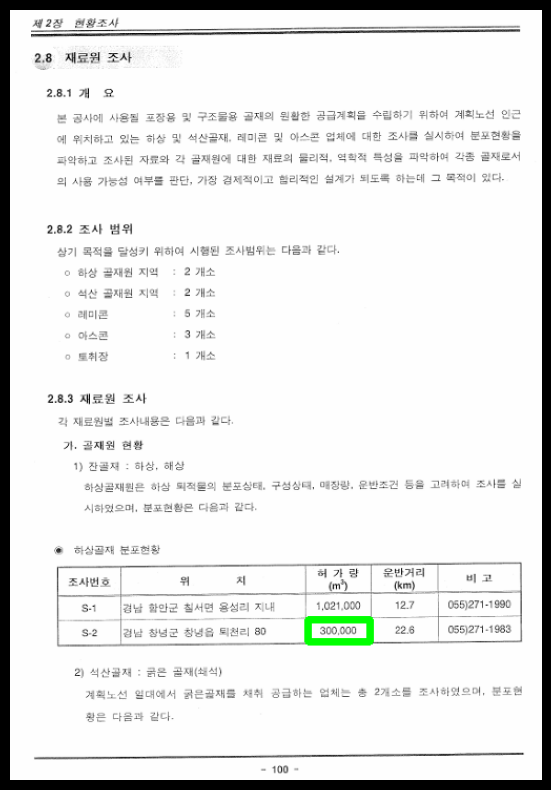

In [27]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("/home/skhong/ocr_proj/data/construct/r_image/r_image_50.png")

x_px, y_px, w_px, h_px = (283,    580,     59,     21)

vis_img = image.copy()
cv2.rectangle(vis_img, (x_px, y_px), (x_px + w_px, y_px + h_px), (0, 255, 0), 5)  # 초록색 박스

# === 7. matplotlib으로 시각화 (RGB로 변환) ===
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [16]:
import numpy as np
def table_objection(img_path):
    image = cv2.imread(img_path)
    if image is None: return None, []
    gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, img_bin = cv2.threshold(gray_scale, 223, 225, cv2.THRESH_BINARY)
    img_bin = ~img_bin
    line_min_width = 15
    kernal_h = np.ones((1, line_min_width), np.uint8)
    kernal_v = np.ones((line_min_width, 1), np.uint8)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    img_bin_final = img_bin_h | img_bin_v
    final_kernel = np.ones((3, 3), np.uint8)
    img_bin_final = cv2.dilate(img_bin_final, final_kernel, iterations=1)
    _, _, stats, _ = cv2.connectedComponentsWithStats(~img_bin_final, connectivity=8, ltype=cv2.CV_32S)
    return image, stats

image, stats = table_objection("/home/skhong/ocr_proj/data/construct/r_image/r_image_50.png")

In [18]:
stats

array([[    19,     14,    471,    701,  14226],
       [     0,      0,    506,    733, 329716],
       [   345,    529,     60,     24,   1384],
       [   409,    528,     75,     24,   1738],
       [   107,    530,    173,     25,   4012],
       [   283,    530,     59,     23,   1357],
       [    47,    532,     57,     24,   1362],
       [   283,    557,     59,     20,   1158],
       [   345,    556,     61,     21,   1202],
       [   409,    556,     75,     44,   3071],
       [   107,    558,    173,     21,   3424],
       [    47,    560,     57,     20,   1127],
       [   345,    579,     61,     22,   1262],
       [   107,    581,    173,     21,   3505],
       [   283,    580,     59,     21,   1231],
       [    47,    583,     57,     20,   1123]], dtype=int32)